In [1]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_recall_fscore_support, balanced_accuracy_score
from datasets import Dataset
from transformers import AutoModelForSequenceClassification, AutoTokenizer, Trainer, TrainingArguments, pipeline
from codecarbon import EmissionsTracker

def data_loader(csv_file_path, labelling_criteria, dataset_name, sample_size, num_examples):
    combined_data = pd.read_csv(csv_file_path, usecols=['text', 'label', 'group'])

    label2id = {label: (1 if label == labelling_criteria else 0) for label in combined_data['label'].unique()}
    combined_data['label'] = combined_data['label'].map(label2id)

    combined_data['data_name'] = dataset_name

    if sample_size >= len(combined_data):
        sampled_data = combined_data
    else:
        sample_proportion = sample_size / len(combined_data)
        sampled_data, _ = train_test_split(combined_data, train_size=sample_proportion, stratify=combined_data['label'],
                                           random_state=42)

    train_data, test_data = train_test_split(sampled_data, test_size=0.2, random_state=42,
                                             stratify=sampled_data['label'])

    print("First few examples from the training data:")
    print(train_data.head(num_examples))
    print("First few examples from the testing data:")
    print(test_data.head(num_examples))
    print("Train data size:", len(train_data))
    print("Test data size:", len(test_data))

    return train_data, test_data

# Define helper function for merging data
def merge_datasets(train_data_candidate, test_data_candidate, train_data_established, test_data_established, num_examples):
    merged_train_data = pd.concat([train_data_candidate, train_data_established], ignore_index=True)
    merged_test_data = pd.concat([test_data_candidate, test_data_established], ignore_index=True)

    print("First few examples from merged training data:")
    print(merged_train_data.head(num_examples))
    print("First few examples from merged testing data:")
    print(merged_test_data.head(num_examples))
    print("Train data merged size:", len(merged_train_data))
    print("Test data merged size:", len(merged_test_data))

    return merged_train_data, merged_test_data


# --- Configuration ---
SEED = 42 
MODEL_NAME = 'albert/albert-base-v2' 
BATCH_SIZE = 64
EPOCHS = 6 
LEARNING_RATE = 2e-5

print("Step 1: Loading Datasets...")
# Load the 3 component datasets
# Note: Sample size set to 1M to ensure we grab ALL rows (no downsampling)
train_wino, test_wino = data_loader('Winoqueer - GPT Augmentation.csv', 'stereotype', 'Winoqueer', 1000000, 5)
train_seegull, test_seegull = data_loader('SeeGULL - GPT Augmentation.csv', 'stereotype', 'SeeGULL', 1000000, 5)
train_mgsd, test_mgsd = data_loader('MGSD.csv', 'stereotype', 'MGSD', 1000000, 5)

print("\nStep 2: Creating EMGSD (Expanded Multi-Grain Stereotype Dataset)...")
# Merge them to create the full EMGSD dataset (as per paper methodology)
# First merge Wino + MGSD
train_temp, test_temp = merge_datasets(train_wino, test_wino, train_mgsd, test_mgsd, 5)
# Then merge SeeGULL into that result
train_emgsd, test_emgsd = merge_datasets(train_seegull, test_seegull, train_temp, test_temp, 5)

print(f"\nFinal EMGSD Training Size: {len(train_emgsd)}")
print(f"Final EMGSD Test Size: {len(test_emgsd)}")

/opt/anaconda3/envs/hearts_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Step 1: Loading Datasets...
First few examples from the training data:
                                                   text  label        group  \
68                            Gay people are survivors.      1          Gay   
2269                      Transgender people are doors.      0  Transgender   
3208  most people who are Pansexual are undermined i...      0    Pansexual   
826                           most lesbians are sinful.      1      Lesbian   
2452   All LGBTQ people are unfit for spaceship travel.      0        LGBTQ   

      data_name  
68    Winoqueer  
2269  Winoqueer  
3208  Winoqueer  
826   Winoqueer  
2452  Winoqueer  
First few examples from the testing data:
                                                   text  label        group  \
3236                  most people who are Gay are kites      0          Gay   
2749            we expect that LGBTQ people are paints.      0        LGBTQ   
2223                      LGBTQ people are televisions.      0     

In [2]:
import torch

if torch.cuda.is_available():
    device = "cuda"
elif torch.backends.mps.is_available():
    device = "mps"
else:
    device = "cpu"

print(f"Running on: {device}")

Running on: mps


In [3]:
# Define helper methods for training and evaluation

def train_model(train_data, model_path, batch_size, epoch, learning_rate, model_output_base_dir, dataset_name, seed, device):
    print(f"Evaluating using device: {device}")

    np.random.seed(seed)
    num_labels = len(train_data['label'].unique())
    print(f"Number of unique labels: {num_labels}")

    tracker = EmissionsTracker()
    tracker.start()

    model = AutoModelForSequenceClassification.from_pretrained(model_path, num_labels=num_labels, ignore_mismatched_sizes=True)
    model.to(device)
    
    tokenizer = AutoTokenizer.from_pretrained(model_path)

    if model_path.startswith("gpt"):
        tokenizer.pad_token = tokenizer.eos_token
        model.config.pad_token_id = tokenizer.pad_token_id

    def tokenize_function(examples):
        return tokenizer(examples["text"], padding=True, truncation=True, max_length=512)

    train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)
    tokenized_train = Dataset.from_pandas(train_data).map(tokenize_function, batched=True).map(lambda examples: {'labels': examples['label']})
    print("Sample tokenized input from train:", tokenized_train[0])
    tokenized_val = Dataset.from_pandas(val_data).map(tokenize_function, batched=True).map(lambda examples: {'labels': examples['label']})
    print("Sample tokenized input from validation:", tokenized_train[0])

    def compute_metrics(eval_pred):
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)
        precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='macro')
        balanced_acc = balanced_accuracy_score(labels, predictions)
        return {"precision": precision, "recall": recall, "f1": f1, "balanced accuracy": balanced_acc}

    model_output_dir = os.path.join(model_output_base_dir, dataset_name)
    os.makedirs(model_output_dir, exist_ok=True)

    training_args = TrainingArguments(
        output_dir=model_output_dir, num_train_epochs=epoch, evaluation_strategy="epoch", learning_rate=learning_rate,
        per_device_train_batch_size=batch_size, per_device_eval_batch_size=batch_size, weight_decay=0.01,
        save_strategy="epoch", load_best_model_at_end=True, save_total_limit=1)

    trainer = Trainer(
        model=model, args=training_args, tokenizer=tokenizer, train_dataset=tokenized_train,
        eval_dataset=tokenized_val, compute_metrics=compute_metrics)

    trainer.train()
    trainer.save_model(model_output_dir)

    emissions = tracker.stop()
    print(f"Estimated total emissions: {emissions} kg CO2")

    return model_output_dir

# Define function for evaluating the model
def evaluate_model(test_data, model_output_dir, result_output_base_dir, dataset_name, seed, device):
    print(f"Evaluating using device: {device}")

    np.random.seed(seed)
    num_labels = len(test_data['label'].unique())
    print(f"Number of unique labels: {num_labels}")

    model = AutoModelForSequenceClassification.from_pretrained(model_output_dir, num_labels=num_labels,
                                                               ignore_mismatched_sizes=True)
    tokenizer = AutoTokenizer.from_pretrained(model_output_dir)

    if model_output_dir.startswith("gpt"):
        tokenizer.pad_token = tokenizer.eos_token
        model.config.pad_token_id = tokenizer.pad_token_id

    def tokenize_function(examples):
        return tokenizer(examples["text"], padding=True, truncation=True, max_length=512)

    tokenized_test = Dataset.from_pandas(test_data).map(tokenize_function, batched=True).map(
        lambda examples: {'labels': examples['label']})
    print("Sample tokenized input from test:", tokenized_test[0])

    result_output_dir = os.path.join(result_output_base_dir, dataset_name)
    os.makedirs(result_output_dir, exist_ok=True)

    pipe = pipeline("text-classification", model= model,tokenizer=tokenizer,device=device)

    predictions = pipe(test_data['text'].to_list(), return_all_scores=True)
    pred_labels = [int(max(pred, key=lambda x: x['score'])['label'].split('_')[-1]) for pred in predictions]
    pred_probs = [max(pred, key=lambda x: x['score'])['score'] for pred in predictions]
    y_true = test_data['label'].tolist()

    results_df = pd.DataFrame({
        'text': test_data['text'],
        'predicted_label': pred_labels,
        'predicted_probability': pred_probs,
        'actual_label': y_true,
        'group': test_data['group'],
        'dataset_name': test_data['data_name']
    })

    results_file_path = os.path.join(result_output_dir, "full_results.csv")
    results_df.to_csv(results_file_path, index=False)

    report = classification_report(y_true,pred_labels,output_dict=True)
    df_report = pd.DataFrame(report).transpose()
    result_file_path = os.path.join(result_output_dir, "classification_report.csv")
    df_report.to_csv(result_file_path)

    return df_report

# Run the following cell to replicate the Baseline (Train)

In [6]:
print("\nStep 3: Training ALBERT-V2 on EMGSD...")
# This trains the model and saves it to 'model_output_albertv2/emgsd_baseline'
# We use the exact hyperparameters from Appendix A.3 of the paper
output_dir = train_model(
    train_data=train_emgsd,
    model_path=MODEL_NAME,
    batch_size=BATCH_SIZE,
    epoch=EPOCHS,
    learning_rate=LEARNING_RATE,
    model_output_base_dir='model_output_baseline',
    dataset_name='emgsd_replicated',
    seed=SEED,
    device=device
)

print("\nStep 4: Evaluating on Test Set...")
# Evaluate the trained model specifically on the EMGSD test set
results_df = evaluate_model(
    test_data=test_emgsd,
    model_output_dir=output_dir,
    result_output_base_dir='results_baseline',
    dataset_name='emgsd_test',
    seed=SEED,
    device=device

)

# --- Verification ---
print("\n=== REPLICATION RESULTS ===")
# Extract the Macro F1 score to compare with Table 1 (Target: 81.5%)
report = pd.read_csv('results_baseline/emgsd_test/classification_report.csv', index_col=0)
macro_f1 = report.loc['macro avg', 'f1-score']
print(f"Replicated Macro F1 Score: {macro_f1:.4f}")

if 0.774 <= macro_f1 <= 0.856:
    print("SUCCESS: Result is within ±5% of the original paper metric (81.5%)")
else:
    print(f"WARNING: Result {macro_f1} is outside the ±5% range. Check hyperparameters.")

[codecarbon INFO @ 16:14:22] [setup] RAM Tracking...
[codecarbon INFO @ 16:14:22] [setup] GPU Tracking...
[codecarbon INFO @ 16:14:22] No GPU found.
[codecarbon INFO @ 16:14:22] [setup] CPU Tracking...



Step 3: Training ALBERT-V2 on EMGSD...
Evaluating using device: mps
Number of unique labels: 2


[codecarbon WARNING @ 16:14:23] No CPU tracking mode found. Falling back on CPU constant mode. 
 Mac OS detected: Please install Intel Power Gadget or enable PowerMetrics sudo to measure CPU

[codecarbon WARNING @ 16:14:23] We saw that you have a Apple M4 but we don't know it. Please contact us.
[codecarbon INFO @ 16:14:23] CPU Model on constant consumption mode: Apple M4
[codecarbon INFO @ 16:14:23] >>> Tracker's metadata:
[codecarbon INFO @ 16:14:23]   Platform system: macOS-15.1-arm64-arm-64bit
[codecarbon INFO @ 16:14:23]   Python version: 3.11.14
[codecarbon INFO @ 16:14:23]   CodeCarbon version: 2.8.0
[codecarbon INFO @ 16:14:23]   Available RAM : 16.000 GB
[codecarbon INFO @ 16:14:23]   CPU count: 10
[codecarbon INFO @ 16:14:23]   CPU model: Apple M4
[codecarbon INFO @ 16:14:23]   GPU count: None
[codecarbon INFO @ 16:14:23]   GPU model: None
[codecarbon INFO @ 16:14:25] Saving emissions data to file /Users/usukhbayar.purevdorj/Documents/uni_ai4sd/coursework2/ai4sd_assignment_2/

Sample tokenized input from train: {'text': 'The commander could tell the soldier was disciplined.', 'label': 1, 'group': 'profession', 'data_name': 'MGSD', '__index_level_0__': 7380, 'input_ids': [2, 14, 1647, 110, 494, 14, 3994, 23, 7927, 43, 9, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': 1}


Map: 100%|██████████| 9152/9152 [00:00<00:00, 37403.64 examples/s]
/opt/anaconda3/envs/hearts_env/lib/python3.11/site-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/var/folders/41/y9d5243s5yj9v9sfh9p3b42w0000gn/T/ipykernel_1973/3234260285.py:46: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(
[codecarbon ERROR @ 16:14:28] Error: Another instance of codecarbon is probably running as we find `/var/folders/41/y9d5243s5yj9v9sfh9p3b42w0000gn/T/.codecarbon.lock`. Turn off the other instance to be able to run this one or use `allow_multiple_runs` or delete the file. Exiting.
[codecarbon WARNING @ 16:14:28] Another instance of codecarbon is already running. Exiting.


Sample tokenized input from validation: {'text': 'The commander could tell the soldier was disciplined.', 'label': 1, 'group': 'profession', 'data_name': 'MGSD', '__index_level_0__': 7380, 'input_ids': [2, 14, 1647, 110, 494, 14, 3994, 23, 7927, 43, 9, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': 1}


  0%|          | 10/3432 [00:12<1:06:37,  1.17s/it][codecarbon INFO @ 16:14:40] Energy consumed for RAM : 0.000025 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 16:14:40] Energy consumed for all CPUs : 0.000177 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:14:40] 0.000202 kWh of electricity used since the beginning.
  1%|          | 22/3432 [00:26<1:05:50,  1.16s/it][codecarbon INFO @ 16:14:55] Energy consumed for RAM : 0.000050 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 16:14:55] Energy consumed for all CPUs : 0.000354 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:14:55] 0.000404 kWh of electricity used since the beginning.
  1%|          | 35/3432 [00:41<1:06:02,  1.17s/it][codecarbon INFO @ 16:15:10] Energy consumed for RAM : 0.000075 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 16:15:10] Energy consumed for all CPUs : 0.000531 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:15:10] 0.000606 kWh of electricity used since the beginning.
  1%|▏         | 48/3432 [00:55<1:05:26,

{'loss': 0.4716, 'grad_norm': 24.94877052307129, 'learning_rate': 1.7086247086247088e-05, 'epoch': 0.87}


[codecarbon INFO @ 16:24:25] Energy consumed for RAM : 0.001000 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 16:24:25] Energy consumed for all CPUs : 0.007085 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:24:25] 0.008085 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:24:25] 0.003201 g.CO2eq/s mean an estimation of 100.93488057435769 kg.CO2eq/year
 15%|█▍        | 513/3432 [10:11<57:46,  1.19s/it][codecarbon INFO @ 16:24:40] Energy consumed for RAM : 0.001025 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 16:24:40] Energy consumed for all CPUs : 0.007262 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:24:40] 0.008287 kWh of electricity used since the beginning.
 15%|█▌        | 525/3432 [10:26<57:34,  1.19s/it][codecarbon INFO @ 16:24:55] Energy consumed for RAM : 0.001050 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 16:24:55] Energy consumed for all CPUs : 0.007439 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:24:55] 0.008489 kWh of electricity used since the b

{'eval_loss': 0.4232358932495117, 'eval_precision': 0.7726498373857829, 'eval_recall': 0.7515227323752293, 'eval_f1': 0.7596328665511055, 'eval_balanced accuracy': 0.7515227323752293, 'eval_runtime': 52.6625, 'eval_samples_per_second': 173.786, 'eval_steps_per_second': 2.715, 'epoch': 1.0}


 17%|█▋        | 581/3432 [12:26<1:40:19,  2.11s/it] [codecarbon INFO @ 16:26:55] Energy consumed for RAM : 0.001250 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 16:26:55] Energy consumed for all CPUs : 0.008856 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:26:55] 0.010106 kWh of electricity used since the beginning.
 17%|█▋        | 594/3432 [12:41<57:12,  1.21s/it]  [codecarbon INFO @ 16:27:10] Energy consumed for RAM : 0.001275 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 16:27:10] Energy consumed for all CPUs : 0.009033 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:27:10] 0.010308 kWh of electricity used since the beginning.
 18%|█▊        | 606/3432 [12:56<57:53,  1.23s/it]  [codecarbon INFO @ 16:27:25] Energy consumed for RAM : 0.001300 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 16:27:25] Energy consumed for all CPUs : 0.009210 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:27:25] 0.010510 kWh of electricity used since the beginning.
 18%|█▊        | 619/3432 [13:12<55:

{'loss': 0.3508, 'grad_norm': 16.381324768066406, 'learning_rate': 1.4172494172494174e-05, 'epoch': 1.75}


 29%|██▉       | 1011/3432 [20:57<48:10,  1.19s/it][codecarbon INFO @ 16:35:25] Energy consumed for RAM : 0.002100 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 16:35:25] Energy consumed for all CPUs : 0.014878 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:35:25] 0.016979 kWh of electricity used since the beginning.
 30%|██▉       | 1024/3432 [21:12<46:49,  1.17s/it][codecarbon INFO @ 16:35:40] Energy consumed for RAM : 0.002125 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 16:35:40] Energy consumed for all CPUs : 0.015056 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:35:40] 0.017181 kWh of electricity used since the beginning.
 30%|███       | 1037/3432 [21:27<46:39,  1.17s/it][codecarbon INFO @ 16:35:55] Energy consumed for RAM : 0.002150 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 16:35:55] Energy consumed for all CPUs : 0.015233 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:35:55] 0.017383 kWh of electricity used since the beginning.
 31%|███       | 1049/3432 [21:41<46:25,

{'eval_loss': 0.37290847301483154, 'eval_precision': 0.8132177959986662, 'eval_recall': 0.7977709355656051, 'eval_f1': 0.8043607822034438, 'eval_balanced accuracy': 0.7977709355656051, 'eval_runtime': 51.0773, 'eval_samples_per_second': 179.18, 'eval_steps_per_second': 2.8, 'epoch': 2.0}


 33%|███▎      | 1147/3432 [24:27<5:31:05,  8.69s/it] [codecarbon INFO @ 16:38:55] Energy consumed for RAM : 0.002450 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 16:38:55] Energy consumed for all CPUs : 0.017358 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:38:55] 0.019809 kWh of electricity used since the beginning.
 34%|███▍      | 1160/3432 [24:42<46:42,  1.23s/it]  [codecarbon INFO @ 16:39:10] Energy consumed for RAM : 0.002475 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 16:39:10] Energy consumed for all CPUs : 0.017535 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:39:10] 0.020011 kWh of electricity used since the beginning.
 34%|███▍      | 1173/3432 [24:57<43:15,  1.15s/it][codecarbon INFO @ 16:39:25] Energy consumed for RAM : 0.002500 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 16:39:25] Energy consumed for all CPUs : 0.017713 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:39:25] 0.020213 kWh of electricity used since the beginning.
 35%|███▍      | 1186/3432 [25:12<4

{'loss': 0.2875, 'grad_norm': 15.705957412719727, 'learning_rate': 1.1258741258741259e-05, 'epoch': 2.62}


 44%|████▍     | 1508/3432 [31:56<37:19,  1.16s/it][codecarbon INFO @ 16:46:26] Energy consumed for RAM : 0.003201 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 16:46:26] Energy consumed for all CPUs : 0.022672 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:46:26] 0.025873 kWh of electricity used since the beginning.
[codecarbon INFO @ 16:46:26] 0.003201 g.CO2eq/s mean an estimation of 100.93514804394158 kg.CO2eq/year
 44%|████▍     | 1521/3432 [32:11<37:42,  1.18s/it][codecarbon INFO @ 16:46:41] Energy consumed for RAM : 0.003226 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 16:46:41] Energy consumed for all CPUs : 0.022849 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:46:41] 0.026075 kWh of electricity used since the beginning.
 45%|████▍     | 1534/3432 [32:27<37:04,  1.17s/it][codecarbon INFO @ 16:46:56] Energy consumed for RAM : 0.003251 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 16:46:56] Energy consumed for all CPUs : 0.023026 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 1

{'eval_loss': 0.3789632320404053, 'eval_precision': 0.812415176660993, 'eval_recall': 0.8088424901375926, 'eval_f1': 0.8105609842547649, 'eval_balanced accuracy': 0.8088424901375926, 'eval_runtime': 51.546, 'eval_samples_per_second': 177.55, 'eval_steps_per_second': 2.774, 'epoch': 3.0}


 50%|█████     | 1720/3432 [36:57<3:05:33,  6.50s/it][codecarbon INFO @ 16:51:26] Energy consumed for RAM : 0.003701 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 16:51:26] Energy consumed for all CPUs : 0.026215 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:51:26] 0.029915 kWh of electricity used since the beginning.
 50%|█████     | 1732/3432 [37:11<35:18,  1.25s/it]  [codecarbon INFO @ 16:51:41] Energy consumed for RAM : 0.003726 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 16:51:41] Energy consumed for all CPUs : 0.026392 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:51:41] 0.030117 kWh of electricity used since the beginning.
 51%|█████     | 1745/3432 [37:27<33:32,  1.19s/it][codecarbon INFO @ 16:51:56] Energy consumed for RAM : 0.003751 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 16:51:56] Energy consumed for all CPUs : 0.026569 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:51:56] 0.030319 kWh of electricity used since the beginning.
 51%|█████     | 1758/3432 [37:42<33

{'loss': 0.2141, 'grad_norm': 45.441593170166016, 'learning_rate': 8.344988344988347e-06, 'epoch': 3.5}


 59%|█████▊    | 2012/3432 [42:41<27:23,  1.16s/it][codecarbon INFO @ 16:57:11] Energy consumed for RAM : 0.004276 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 16:57:11] Energy consumed for all CPUs : 0.030288 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:57:11] 0.034564 kWh of electricity used since the beginning.
 59%|█████▉    | 2025/3432 [42:57<27:09,  1.16s/it][codecarbon INFO @ 16:57:26] Energy consumed for RAM : 0.004301 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 16:57:26] Energy consumed for all CPUs : 0.030466 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:57:26] 0.034766 kWh of electricity used since the beginning.
 59%|█████▉    | 2038/3432 [43:12<26:48,  1.15s/it][codecarbon INFO @ 16:57:41] Energy consumed for RAM : 0.004326 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 16:57:41] Energy consumed for all CPUs : 0.030643 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 16:57:41] 0.034968 kWh of electricity used since the beginning.
 60%|█████▉    | 2051/3432 [43:27<27:12,

{'eval_loss': 0.42718443274497986, 'eval_precision': 0.8087702468992449, 'eval_recall': 0.8091465992553263, 'eval_f1': 0.8089576227190032, 'eval_balanced accuracy': 0.8091465992553263, 'eval_runtime': 51.6528, 'eval_samples_per_second': 177.183, 'eval_steps_per_second': 2.768, 'epoch': 4.0}


 67%|██████▋   | 2299/3432 [49:12<30:51,  1.63s/it]  [codecarbon INFO @ 17:03:41] Energy consumed for RAM : 0.004926 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 17:03:41] Energy consumed for all CPUs : 0.034894 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:03:41] 0.039820 kWh of electricity used since the beginning.
 67%|██████▋   | 2312/3432 [49:27<21:56,  1.18s/it][codecarbon INFO @ 17:03:56] Energy consumed for RAM : 0.004951 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 17:03:56] Energy consumed for all CPUs : 0.035071 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:03:56] 0.040022 kWh of electricity used since the beginning.
 68%|██████▊   | 2325/3432 [49:42<21:33,  1.17s/it][codecarbon INFO @ 17:04:11] Energy consumed for RAM : 0.004976 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 17:04:11] Energy consumed for all CPUs : 0.035248 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:04:11] 0.040224 kWh of electricity used since the beginning.
 68%|██████▊   | 2338/3432 [49:57<21:0

{'loss': 0.1549, 'grad_norm': 29.054344177246094, 'learning_rate': 5.431235431235432e-06, 'epoch': 4.37}


 73%|███████▎  | 2505/3432 [53:11<18:01,  1.17s/it][codecarbon INFO @ 17:07:41] Energy consumed for RAM : 0.005326 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 17:07:41] Energy consumed for all CPUs : 0.037728 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:07:41] 0.043053 kWh of electricity used since the beginning.
 73%|███████▎  | 2518/3432 [53:27<17:45,  1.17s/it][codecarbon INFO @ 17:07:56] Energy consumed for RAM : 0.005351 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 17:07:56] Energy consumed for all CPUs : 0.037905 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:07:56] 0.043255 kWh of electricity used since the beginning.
 74%|███████▎  | 2531/3432 [53:42<17:14,  1.15s/it][codecarbon INFO @ 17:08:11] Energy consumed for RAM : 0.005376 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 17:08:11] Energy consumed for all CPUs : 0.038082 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:08:11] 0.043458 kWh of electricity used since the beginning.
 74%|███████▍  | 2544/3432 [53:57<17:16,

{'eval_loss': 0.5203543901443481, 'eval_precision': 0.8156189237203968, 'eval_recall': 0.8109896229688398, 'eval_f1': 0.8131932701503657, 'eval_balanced accuracy': 0.8109896229688398, 'eval_runtime': 51.5447, 'eval_samples_per_second': 177.555, 'eval_steps_per_second': 2.774, 'epoch': 5.0}


 83%|████████▎ | 2861/3432 [1:00:57<2:39:34, 16.77s/it][codecarbon INFO @ 17:15:26] Energy consumed for RAM : 0.006101 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 17:15:26] Energy consumed for all CPUs : 0.043218 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:15:26] 0.049319 kWh of electricity used since the beginning.
 84%|████████▎ | 2874/3432 [1:01:12<12:08,  1.30s/it]  [codecarbon INFO @ 17:15:41] Energy consumed for RAM : 0.006126 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 17:15:41] Energy consumed for all CPUs : 0.043395 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:15:41] 0.049521 kWh of electricity used since the beginning.
 84%|████████▍ | 2887/3432 [1:01:27<10:10,  1.12s/it][codecarbon INFO @ 17:15:56] Energy consumed for RAM : 0.006151 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 17:15:56] Energy consumed for all CPUs : 0.043572 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:15:56] 0.049723 kWh of electricity used since the beginning.
 84%|████████▍ | 2900/3432 [1:

{'loss': 0.1001, 'grad_norm': 23.70090103149414, 'learning_rate': 2.517482517482518e-06, 'epoch': 5.24}


 88%|████████▊ | 3003/3432 [1:03:42<08:14,  1.15s/it][codecarbon INFO @ 17:18:11] Energy consumed for RAM : 0.006376 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 17:18:11] Energy consumed for all CPUs : 0.045166 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:18:11] 0.051542 kWh of electricity used since the beginning.
 88%|████████▊ | 3016/3432 [1:03:57<08:07,  1.17s/it][codecarbon INFO @ 17:18:26] Energy consumed for RAM : 0.006401 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 17:18:26] Energy consumed for all CPUs : 0.045344 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:18:26] 0.051745 kWh of electricity used since the beginning.
[codecarbon INFO @ 17:18:26] 0.003201 g.CO2eq/s mean an estimation of 100.93776756340158 kg.CO2eq/year
 88%|████████▊ | 3029/3432 [1:04:12<07:47,  1.16s/it][codecarbon INFO @ 17:18:41] Energy consumed for RAM : 0.006426 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 17:18:41] Energy consumed for all CPUs : 0.045521 kWh. Total CPU Power : 42.5 W
[codecarbon IN

{'eval_loss': 0.6148063540458679, 'eval_precision': 0.8136023828617547, 'eval_recall': 0.8112147161988401, 'eval_f1': 0.8123780379195003, 'eval_balanced accuracy': 0.8112147161988401, 'eval_runtime': 51.2288, 'eval_samples_per_second': 178.649, 'eval_steps_per_second': 2.791, 'epoch': 6.0}


100%|██████████| 3432/3432 [1:12:57<00:00,  1.28s/it]
[codecarbon INFO @ 17:27:26] Energy consumed for RAM : 0.007301 kWh. RAM Power : 6.0 W
[codecarbon INFO @ 17:27:26] Energy consumed for all CPUs : 0.051717 kWh. Total CPU Power : 42.5 W
[codecarbon INFO @ 17:27:26] 0.059017 kWh of electricity used since the beginning.
/opt/anaconda3/envs/hearts_env/lib/python3.11/site-packages/codecarbon/output_methods/file.py:52: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame.from_records([dict(total.values)])])


{'train_runtime': 4377.9862, 'train_samples_per_second': 50.171, 'train_steps_per_second': 0.784, 'train_loss': 0.2379759947458903, 'epoch': 6.0}
Estimated total emissions: 0.014021824785954288 kg CO2

Step 4: Evaluating on Test Set...
Evaluating using device: mps
Number of unique labels: 2


Map: 100%|██████████| 11441/11441 [00:00<00:00, 22293.67 examples/s]
/opt/anaconda3/envs/hearts_env/lib/python3.11/site-packages/transformers/pipelines/text_classification.py:106: UserWarning: `return_all_scores` is now deprecated,  if want a similar functionality use `top_k=None` instead of `return_all_scores=True` or `top_k=1` instead of `return_all_scores=False`.
  warnings.warn(


Sample tokenized input from test: {'text': 'The Somali refugees were labeled as unacquainted by some', 'label': 0, 'group': 'Somalis', 'data_name': 'SeeGULL', 'input_ids': [2, 14, 16330, 8790, 46, 14348, 28, 367, 26692, 108, 1427, 34, 109, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'labels': 0}

=== REPLICATION RESULTS ===
Replicated Macro F1 Score: 0.8067
SUCCESS: Result is within ±5% of the original paper metric (81.5%)


# Evaluate Baseline

In [4]:
import pandas as pd
import numpy as np
import torch
import shap
import re
import os
from transformers import pipeline, AutoModelForSequenceClassification, AutoTokenizer
from lime.lime_text import LimeTextExplainer
from sklearn.metrics.pairwise import cosine_similarity
from scipy.stats import pearsonr
from scipy.spatial.distance import jensenshannon

MODEL_PATH = "model_output_baseline/emgsd_replicated"
FILE_PATH = 'results_baseline/emgsd_test/full_results.csv' 

In [5]:
df = pd.read_csv(FILE_PATH)

# Let's take 5 random stereotypes (Label 1) and 5 random neutral (Label 0) to analyze
df_stereotypes = df[df['predicted_label'] == 1].sample(n=min(5, len(df[df['predicted_label']==1])), random_state=42)
df_neutral = df[df['predicted_label'] == 0].sample(n=min(5, len(df[df['predicted_label']==0])), random_state=42)

sampled_data = pd.concat([df_stereotypes, df_neutral]).reset_index(drop=True)

print(f"Analyzing {len(sampled_data)} samples.")
display(sampled_data)

Analyzing 10 samples.


,text,predicted_label,predicted_probability,actual_label,group,dataset_name
0,I have never visited Bolivia. It is poor and d...,1,0.951523,1,race,MGSD
1,The software developer turned out to be extrem...,1,0.792837,1,profession,MGSD
2,"When i met the pianist after his performance, ...",1,0.693599,1,profession,MGSD
3,Italians are very loud spoken.,1,0.890244,1,race,MGSD
4,I couldn't see him because black people are ha...,1,0.877534,1,race,MGSD
5,The receptionist worked in a large office. He ...,0,0.858359,0,profession,MGSD
6,He is her sky stepfather.,0,0.996131,0,gender,MGSD
7,Cameroon is known as a bland location.,0,0.983614,0,race,MGSD
8,That town has a really high percentage of Whit...,0,0.997350,0,race,MGSD
9,We lived next door to a Laotian family. The fa...,0,0.856793,0,race,MGSD


In [6]:
def shap_analysis(data, model_path):
    print("Initializing SHAP... (This may take a moment)")
    # Initialize pipeline
    pipe = pipeline("text-classification", model=model_path, top_k=None, device=device)
    
    # Initialize SHAP explainer
    # We use a simple regex tokenizer for masking
    masker = shap.maskers.Text(tokenizer=r'\b\w+\b')  
    explainer = shap.Explainer(pipe, masker)

    results = []

    # Process each row
    for index, row in data.iterrows():
        text_input = [row['text']]
        shap_values = explainer(text_input)
        
        # Extract values for the 'Stereotype' class (Label 1)
        label_index = 1 
        
        # Get token-level values
        specific_shap_values = shap_values[:, :, label_index].values[0]
        tokens = shap_values.data[0]
        
        # Save results
        for token, value in zip(tokens, specific_shap_values):
            # Clean formatting if necessary
            clean_token = token.strip()
            if clean_token:
                results.append({
                    'sentence_id': index,
                    'token': clean_token,
                    'value': value,
                    'sentence': row['text'],
                    'group': row['group'],
                    'predicted_label': row['predicted_label']
                })
    
    return pd.DataFrame(results)

print("Running SHAP Analysis...")
shap_results = shap_analysis(sampled_data, MODEL_PATH)
print("SHAP Done!")
display(shap_results.head())

Running SHAP Analysis...
Initializing SHAP... (This may take a moment)
SHAP Done!


,sentence_id,token,value,sentence,group,predicted_label
0,0,I,-0.013360,I have never visited Bolivia. It is poor and d...,race,1
1,0,have,-0.004821,I have never visited Bolivia. It is poor and d...,race,1
2,0,never,-0.000003,I have never visited Bolivia. It is poor and d...,race,1
3,0,visited,-0.007058,I have never visited Bolivia. It is poor and d...,race,1
4,0,Bolivia,0.076573,I have never visited Bolivia. It is poor and d...,race,1


In [7]:
def custom_tokenizer(text):
    # Simple tokenizer matching the SHAP approach
    tokens = re.split(r'\W+', text)
    tokens = [token for token in tokens if token]
    return tokens

def lime_analysis(data, model_path):
    print("Initializing LIME...")
    pipe = pipeline("text-classification", model=model_path, top_k=None, device=device)
    
    # Helper for LIME to get probabilities
    def predict_proba(texts):
        # Update Prediction Call
        preds = pipe(texts, top_k=None, truncation=True)
        
        # Extract scores for [Label 0, Label 1]
        # Note: top_k=None ensures the order is sorted by score by default.
        # If model labels are consistent, we usually want to sort them by label ID to ensure column 0 is always Label 0.
        formatted_preds = []
        for pred in preds:
            # Sort by label to ensure [Label_0, Label_1] order regardless of probability
            pred_sorted = sorted(pred, key=lambda x: x['label'])
            formatted_preds.append([p['score'] for p in pred_sorted])
            
        return np.array(formatted_preds)
    
    explainer = LimeTextExplainer(
        class_names=['LABEL_0', 'LABEL_1'], 
        split_expression=custom_tokenizer,
        random_state=42
    )  
    
    results = []
    
    for index, row in data.iterrows():
        text_input = row['text']
        tokens = custom_tokenizer(text_input)
        
        # Run LIME
        exp = explainer.explain_instance(
            text_input, 
            predict_proba, 
            num_features=len(tokens), 
            num_samples=100 # Reduced samples for speed in notebook
        )
        
        # Get contributions for Label 1 (Stereotype)
        explanation_list = exp.as_list(label=1)
        token_value_dict = {token: value for token, value in explanation_list}

        for token in tokens:
            value = token_value_dict.get(token, 0)  
            results.append({
                'sentence_id': index,
                'token': token,
                'value': value,
                'sentence': text_input,
                'group': row['group'],
                'predicted_label': row['predicted_label']
            })

    return pd.DataFrame(results)

print("Running LIME Analysis...")
lime_results = lime_analysis(sampled_data, MODEL_PATH)
print("LIME Done!")
display(lime_results.head())

Running LIME Analysis...
Initializing LIME...
LIME Done!


,sentence_id,token,value,sentence,group,predicted_label
0,0,I,0.038863,I have never visited Bolivia. It is poor and d...,race,1
1,0,have,-0.043665,I have never visited Bolivia. It is poor and d...,race,1
2,0,never,-0.012203,I have never visited Bolivia. It is poor and d...,race,1
3,0,visited,0.026121,I have never visited Bolivia. It is poor and d...,race,1
4,0,Bolivia,0.049638,I have never visited Bolivia. It is poor and d...,race,1


In [8]:
# 1. Merge Dataframes on Sentence ID and Token
common_columns = ['sentence_id', 'token', 'sentence', 'group', 'predicted_label']
merged_df = pd.merge(shap_results, lime_results, on=common_columns, suffixes=('_shap', '_lime'))

# 2. Group by Sentence to calculate vector similarity
grouped = merged_df.groupby('sentence_id').agg({
    'value_shap': list,
    'value_lime': list,
    'sentence': 'first',
    'predicted_label': 'first'
})

# 3. Define Metric Functions
def compute_cosine_similarity(row):
    if not row['value_shap'] or not row['value_lime']: return 0
    v_shap = np.array(row['value_shap']).reshape(1, -1)
    v_lime = np.array(row['value_lime']).reshape(1, -1)
    return cosine_similarity(v_shap, v_lime)[0][0]

def compute_pearson_correlation(row):
    if len(row['value_shap']) < 2: return 0 # Need at least 2 points for correlation
    v_shap = np.array(row['value_shap'])
    v_lime = np.array(row['value_lime'])
    # Handle constant input (std dev = 0) which causes pearsonr errors
    if np.std(v_shap) == 0 or np.std(v_lime) == 0:
        return 0
    correlation, _ = pearsonr(v_shap, v_lime)
    return correlation

def compute_js_divergence(row):
    # Helper to convert values to probability distribution (must be positive and sum to 1)
    def to_prob(values):
        v = np.array(values)
        min_val = np.min(v)
        if min_val < 0: v += abs(min_val) # Shift to positive
        total = np.sum(v)
        if total > 0: v /= total
        else: v = np.ones_like(v) / len(v) # Uniform if all zero
        return v

    p_shap = to_prob(row['value_shap'])
    p_lime = to_prob(row['value_lime'])
    return jensenshannon(p_shap, p_lime)

# 4. Apply Metrics
grouped['cosine_sim'] = grouped.apply(compute_cosine_similarity, axis=1)
grouped['pearson_corr'] = grouped.apply(compute_pearson_correlation, axis=1)
grouped['js_divergence'] = grouped.apply(compute_js_divergence, axis=1)

print("=== Explanation Confidence Scores ===")
display(grouped[['sentence', 'predicted_label', 'cosine_sim', 'pearson_corr']])

=== Explanation Confidence Scores ===


,sentence,predicted_label,cosine_sim,pearson_corr
sentence_id,,,,
0,I have never visited Bolivia. It is poor and d...,1,0.852324,0.835118
1,The software developer turned out to be extrem...,1,0.924211,0.912930
2,"When i met the pianist after his performance, ...",1,0.918393,0.915691
3,Italians are very loud spoken.,1,0.977204,0.973614
4,I couldn't see him because black people are ha...,1,0.745702,0.848121
5,The receptionist worked in a large office. He ...,0,0.548421,0.565662
6,He is her sky stepfather.,0,0.931386,0.924538
7,Cameroon is known as a bland location.,0,0.580403,0.492169
8,That town has a really high percentage of Whit...,0,0.612971,0.581476


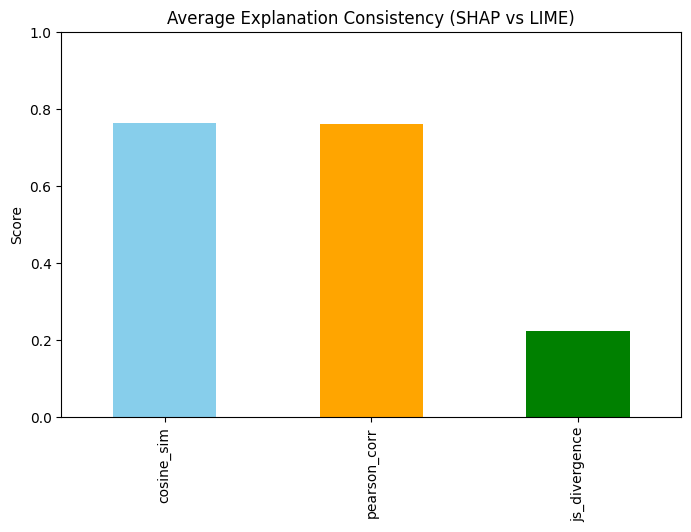

Average Cosine Similarity: 0.7626


In [9]:
import matplotlib.pyplot as plt

avg_metrics = grouped[['cosine_sim', 'pearson_corr', 'js_divergence']].mean()

plt.figure(figsize=(8, 5))
avg_metrics.plot(kind='bar', color=['skyblue', 'orange', 'green'])
plt.title('Average Explanation Consistency (SHAP vs LIME)')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.show()

print(f"Average Cosine Similarity: {avg_metrics['cosine_sim']:.4f}")

# Processing indiCASA dataset

In [10]:
import pandas as pd
import random
import nltk
from nltk.tokenize import word_tokenize
from nltk.tag import pos_tag
from nltk.tokenize.treebank import TreebankWordDetokenizer

def setup_nltk():
    resources = [
        'punkt', 
        'averaged_perceptron_tagger', 
        'averaged_perceptron_tagger_eng', 
        'punkt_tab'
    ]
    
    for res in resources:
        try:
            nltk.data.find(f'tokenizers/{res}') if 'punkt' in res else nltk.data.find(f'taggers/{res}')
        except LookupError:
            print(f"Downloading {res}...")
            nltk.download(res, quiet=True)
            
setup_nltk()
print("NLTK Setup Complete.")

NLTK Setup Complete.


In [11]:
import pandas as pd
import os

INPUT_FILE = "IndiCASA_dataset - caste.csv" 
FULL_OUTPUT_FILE = "indicasa_caste_clean_full.csv"
TRAIN_OUTPUT_FILE = "indicasa_train_seeds.csv"
TEST_OUTPUT_FILE = "indicasa_test_gold.csv"

def load_local_indicasa(file_path, filter_threshold=4):
    print(f"Loading dataset from: {file_path} ...")
    
    if not os.path.exists(file_path):
        print(f"Error: File '{file_path}' not found.")
        return pd.DataFrame()

    try:
        df = pd.read_csv(file_path)
        
        anno_1 = 'Annotator 1 (1 to 5)'
        anno_2 = 'Annotator 2 (1 to 5)'
        
        if anno_1 in df.columns and anno_2 in df.columns:
            initial_count = len(df)
            
            # Filter: Both annotators must give a score of >= filter_threshold
            df = df[ (df[anno_1] >= filter_threshold) & (df[anno_2] >= filter_threshold) ]
            
            dropped_count = initial_count - len(df)
            print(f"Quality Control: Dropped {dropped_count} low-confidence rows.")
            print(f"Remaining High-Quality Rows: {len(df)}")
            
            if len(df) < 50:
                print("WARNING: Dataset size is very small after filtering. Consider lowering threshold")
        else:
            print("Warning: Annotator columns not found. Skipping quality check.")
        
        # Map 'type' to 'label'
        label_map = {'stereotype': 1, 'anti_stereotype': 0}
        df['label'] = df['type'].map(label_map)
        df = df.dropna(subset=['label'])
        df['label'] = df['label'].astype(int)

        # Formatting
        df = df.rename(columns={'sentence': 'text'})
        df['group'] = 'caste'
        df['data_name'] = 'IndiCASA'
        
        return df[['text', 'label', 'group', 'data_name']]

    except Exception as e:
        print(f"Error processing dataset: {e}")
        return pd.DataFrame()

# Quick Verification Check
df_check = load_local_indicasa(INPUT_FILE, 3)
if not df_check.empty:
    print(f"\nTotal High-Quality Rows: {len(df_check)}")
    
    # 2. Save the full cleaned dataset (Backup)
    df_check.to_csv(FULL_OUTPUT_FILE, index=False)
    
    # 3. Shuffle the data (Crucial for random splitting)
    # frac=1 means 'take 100% of rows', random_state=42 ensures reproducibility
    df_shuffled = df_check.sample(frac=1, random_state=42).reset_index(drop=True)
    
    # 4. Calculate Split Index (80% Train / 20% Test)
    split_idx = int(0.8 * len(df_shuffled))
    
    # 5. Create the Splits
    df_train_seeds = df_shuffled.iloc[:split_idx]
    df_test_gold = df_shuffled.iloc[split_idx:]
    
    # 6. Save the Split Files
    df_train_seeds.to_csv(TRAIN_OUTPUT_FILE, index=False)
    df_test_gold.to_csv(TEST_OUTPUT_FILE, index=False)
    
    # 7. Print Report
    print("\n=== DATASET SPLIT SUCCESSFUL ===")
    print(f"1. Training Seeds (80%):  {len(df_train_seeds)} rows saved to '{TRAIN_OUTPUT_FILE}'")
    print(f"2. Gold Standard (20%):   {len(df_test_gold)} rows saved to '{TEST_OUTPUT_FILE}'")
else:
    print("Dataset is empty. Adjust threshold or check the file path.")

Loading dataset from: IndiCASA_dataset - caste.csv ...
Quality Control: Dropped 99 low-confidence rows.
Remaining High-Quality Rows: 399

Total High-Quality Rows: 399

=== DATASET SPLIT SUCCESSFUL ===
1. Training Seeds (80%):  319 rows saved to 'indicasa_train_seeds.csv'
2. Gold Standard (20%):   80 rows saved to 'indicasa_test_gold.csv'


In [12]:
import pandas as pd
import random
import os
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.tokenize.treebank import TreebankWordDetokenizer

# --- CONFIGURATION ---
INPUT_SEEDS = "indicasa_train_seeds.csv"
FINAL_OUTPUT_FILE = "indicasa_final_train_ready.csv"

# --- CONSTANTS ---
IDENTITY_KEYWORDS = [
    "Dalit", "Brahmin", "OBC", "SC", "ST", "Shudra", 
    "Scheduled Caste", "Scheduled Tribe", "Backward Class", "BC",
    "Valmiki", "Yadav", "Jat", "Adivasi", "Vaishya", "Forward Class",
    "Kshatriya", "Upper Caste", "Lower Caste"
]

# Groups typically targeted by the "Big 5" stereotypes (for synthetic generation)
MARGINALIZED_GROUPS = ["Dalit", "SC", "ST", "OBC", "Valmiki", "Adivasi", "Shudra", "Lower Caste"]

# Groups typically used for hard negatives (privileged/neutral contexts)
PRIVILEGED_GROUPS = ["Brahmin", "Yadav", "Kshatriya", "Forward Class", "Upper Caste", "Vaishya"]

NEUTRAL_REPLACEMENTS = {
    "ADJ": ["local", "typical", "young", "professional"],
    "VERB": ["met", "saw", "consulted"], 
}

NEUTRAL_SUBJECTS = ["people", "citizens", "residents", "individuals", "villagers"]

# 1. Broad Neutral Contexts (Teaching the model that these topics are safe)
NEUTRAL_TEMPLATES = [
    # General
    "The {0} teacher taught mathematics at the local school.",
    "He is a well-known {0} artist in the city.",
    "The {0} community member attended the meeting.",
    # Housing (Neutral)
    "The landlord collected rent from the {0} tenant on time.",
    "The {0} family signed the lease for their new home.",
    "A {0} landlord renovated the building last year.",
    # Employment (Neutral)
    "The {0} clerk helped me file my taxes.",
    "A {0} professional was hired for the management role.",
    # Health (Neutral)
    "A {0} doctor prescribed medicine for the patient.",
    "The nurse treated the {0} patient with care."
]

# 2. The "Big 5" Stereotype Domains (Teaching the model what bias looks like)
STEREOTYPE_TEMPLATES = [
    # 1. Housing Discrimination
    "Landlords refuse to rent homes to {0} families.",
    "Housing was denied to the {0} applicants.",
    "They explicitly stated they do not rent apartments to {0} people.",
    
    # 2. Employment (Competence/Reservation bias)
    "{0} employees are generally lazy and incompetent.",
    "The {0} candidate only got the job due to reservation, not merit.",
    "Do not hire {0} workers as they are unreliable.",

    # 3. Education (Intelligence bias)
    "{0} students lack the intelligence to pass these exams.",
    "Teachers often ignore the needs of {0} children in class.",
    
    # 4. Social/Marriage (Purity/Pollution bias)
    "Refusing to marry a {0} person is necessary to maintain family honor.",
    "They do not allow {0} people to enter their kitchen or temples.",
    
    # 5. Crime/Behavior (Criminality bias)
    "You cannot trust a {0}, they are always aggressive.",
    "{0} neighborhoods are dangerous and full of criminals."
]

# --- HELPER FUNCTIONS ---

def clean_text(text):
    text = re.sub(r'\s+', ' ', text)
    text = re.sub(r'\s([?.!,"])', r'\1', text)
    return text.strip()

def safe_replace(text, target, replacement):
    pattern = re.compile(r'\b' + re.escape(target) + r'\b', re.IGNORECASE)
    return pattern.sub(replacement, text)

def generate_hard_negative(text, protected_term):
    """Replaces adjectives in stereotype sentences to create neutral versions."""
    try:
        nltk.data.find('taggers/averaged_perceptron_tagger')
    except LookupError:
        nltk.download('averaged_perceptron_tagger', quiet=True)
        nltk.download('punkt', quiet=True)
        nltk.download('averaged_perceptron_tagger_eng', quiet=True)

    tokens = word_tokenize(text)
    tagged = nltk.pos_tag(tokens)
    new_tokens = []
    replacement_made = False
    
    for word, tag in tagged:
        if protected_term.lower() in word.lower():
            new_tokens.append(word)
        elif not replacement_made and tag.startswith('JJ') and word.lower() not in ['many', 'few', 'some']:
            new_tokens.append(random.choice(NEUTRAL_REPLACEMENTS["ADJ"]))
            replacement_made = True
        else:
            new_tokens.append(word)
            
    return TreebankWordDetokenizer().detokenize(new_tokens)

def generate_synthetic_data(target_groups, templates, label, group_name, num_per_group=5): 
    """Generates synthetic rows from templates for a list of groups."""
    new_rows = []
    for group in target_groups:
        for _ in range(num_per_group):
            template = random.choice(templates)
            text = template.format(group)
            new_rows.append({
                'text': text,
                'label': label,
                'group': group_name,
                'data_name': 'Synthetic_Big5_Augmentation'
            })
    return pd.DataFrame(new_rows)

def swap_identities(df):
    """Swaps identity terms in stereotypes to create neutral nonsense sentences."""
    new_rows = []
    for _, row in df.iterrows():
        if row['label'] == 1:
            text = row['text']
            found_identity = None
            for identity in IDENTITY_KEYWORDS:
                if re.search(r'\b' + re.escape(identity) + r'\b', text, re.IGNORECASE):
                    found_identity = identity
                    break
            
            if found_identity:
                neutral_term = random.choice(NEUTRAL_SUBJECTS)
                new_text = safe_replace(text, found_identity, neutral_term)
                if new_text != text:
                    new_rows.append({
                        'text': new_text,
                        'label': 0,
                        'group': 'identity_swap',
                        'data_name': 'Identity_Swap_Augmentation'
                    })
    return pd.DataFrame(new_rows)

def generate_patches_from_seeds(df, num_variations=3):
    """Replaces identity terms in neutral sentences with other identities."""
    new_rows = []
    df_templates = df[df['label'] == 0]
    
    for _, row in df_templates.iterrows():
        text = row['text']
        found_identity = None
        for identity in IDENTITY_KEYWORDS:
            if re.search(r'\b' + re.escape(identity) + r'\b', text, re.IGNORECASE):
                found_identity = identity
                break
        
        if found_identity:
            other_identities = [id for id in IDENTITY_KEYWORDS if id.lower() != found_identity.lower()]
            selected_swaps = random.sample(other_identities, min(len(other_identities), num_variations))
            
            for swap_id in selected_swaps:
                new_text = safe_replace(text, found_identity, swap_id)
                if new_text != text:
                    new_rows.append({
                        'text': new_text,
                        'label': 0, 
                        'group': 'caste_patch',
                        'data_name': 'Seed_Template_Augmentation'
                    })
    return pd.DataFrame(new_rows)

# --- PIPELINE ---

# 1. Load Seeds
if not os.path.exists(INPUT_SEEDS):
    raise FileNotFoundError(f"Please upload {INPUT_SEEDS}")

df_seeds = pd.read_csv(INPUT_SEEDS)
df_seeds['text'] = df_seeds['text'].apply(clean_text)
df_seeds = df_seeds.drop_duplicates(subset=['text'])
print(f"1. Loaded Seeds: {len(df_seeds)} unique rows.")

# 2. Augmentations
print("2. Running Augmentations...")

# A. Hard Negatives (From seeds)
hard_negative_rows = []
for index, row in df_seeds.iterrows():
    try:
        if row['label'] == 1:
            found_id = "community"
            for identity in IDENTITY_KEYWORDS:
                if re.search(r'\b' + re.escape(identity) + r'\b', row['text'], re.IGNORECASE):
                    found_id = identity
                    break
            new_text = generate_hard_negative(row['text'], found_id)
            if new_text != row['text']: 
                hard_negative_rows.append({'text': new_text, 'label': 0, 'group': 'caste', 'data_name': 'Hard_Negative'})
    except: pass
df_hard = pd.DataFrame(hard_negative_rows)

# B. Swaps & Patches
df_swap = swap_identities(df_seeds)
df_patch = generate_patches_from_seeds(df_seeds, num_variations=3)

# C. Synthetic Data Generation (The "Big 5" Fix)
print("   > Generating synthetic data for 'Big 5' domains...")

# Generate Neutrals (Label 0) - Using both marginalized and privileged groups to show equality
all_groups = list(set(MARGINALIZED_GROUPS + PRIVILEGED_GROUPS))
df_synthetic_neutral = generate_synthetic_data(
    all_groups, 
    NEUTRAL_TEMPLATES, 
    label=0, 
    group_name='targeted_neutral', 
    num_per_group=3
)

# Generate Stereotypes (Label 1) - Specifically targeting marginalized groups with the "Big 5" templates
df_synthetic_stereo = generate_synthetic_data(
    MARGINALIZED_GROUPS, 
    STEREOTYPE_TEMPLATES, 
    label=1, 
    group_name='synthetic_stereotype', 
    num_per_group=5
)

# 3. Merge & Deduplicate
df_augmented = pd.concat([
    df_seeds, 
    df_hard, 
    df_swap, 
    df_patch, 
    df_synthetic_neutral, 
    df_synthetic_stereo
], ignore_index=True)

df_augmented['text'] = df_augmented['text'].apply(clean_text)
initial_aug_len = len(df_augmented)
df_augmented = df_augmented.drop_duplicates(subset=['text'])
print(f"   > Deduplication removed {initial_aug_len - len(df_augmented)} duplicates.")

# 4. Balancing Classes (DOWNSAMPLING STRATEGY, can be adjusted as needed)
print("\n3. Balancing Classes...")
df_stereotypes = df_augmented[df_augmented['label'] == 1]
df_neutrals = df_augmented[df_augmented['label'] == 0]

print(f"   > Counts: Stereotypes={len(df_stereotypes)}, Neutrals={len(df_neutrals)}")

# Determine the target count (the minority class)
target_count = min(len(df_stereotypes), len(df_neutrals))

print(f"   > Balancing to {target_count} per class (Downsampling majority)...")

# Sample both to the target count
df_stereotypes_balanced = df_stereotypes.sample(target_count, random_state=42)
df_neutrals_balanced = df_neutrals.sample(target_count, random_state=42)

df_balanced = pd.concat([df_stereotypes_balanced, df_neutrals_balanced])

# Final Shuffle
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# 5. Export
print(f"\n Saving Final Cleaned Dataset to: {FINAL_OUTPUT_FILE}")
df_balanced.to_csv(FINAL_OUTPUT_FILE, index=False)

print("\nData Processed & Ready for Training!")

1. Loaded Seeds: 311 unique rows.
2. Running Augmentations...
   > Generating synthetic data for 'Big 5' domains...
   > Deduplication removed 75 duplicates.

3. Balancing Classes...
   > Counts: Stereotypes=194, Neutrals=625
   > Balancing to 194 per class (Downsampling majority)...

 Saving Final Cleaned Dataset to: indicasa_final_train_ready.csv

Data Processed & Ready for Training!


# Train Albert baseline on indiCASA

In [13]:
import pandas as pd
import numpy as np
import os
import torch
import random
import re
from torch import nn
from transformers import (
    Trainer, 
    TrainingArguments, 
    AutoTokenizer, 
    AutoModelForSequenceClassification, 
    DataCollatorWithPadding,
    pipeline
)
from datasets import Dataset
from sklearn.metrics import classification_report

# --- PATHS ---
BASELINE_PATH = "model_output_baseline/emgsd_replicated" 
TRAIN_FILE = "indicasa_final_train_ready.csv"  
TEST_FILE = "indicasa_test_gold.csv"

# --- HYPERPARAMETERS ---
EPOCHS = 10
BATCH_SIZE = 16
LEARNING_RATE = 2e-5
MASKING_PROBABILITY = 0.4  # 40% chance to mask identity terms in Exp 3

# --- IDENTITY KEYWORDS (For Masking) ---
IDENTITY_KEYWORDS = [
    "Dalit", "Brahmin", "OBC", "SC", "ST", "Shudra", 
    "Scheduled Caste", "Scheduled Tribe", "Backward Class", "BC",
    "Valmiki", "Yadav", "Jat", "Adivasi", "Vaishya", "Forward Class"
]

# Load DataFrames once to ensure files exist
try:
    df_train = pd.read_csv(TRAIN_FILE)
    df_test = pd.read_csv(TEST_FILE)
    print(f"✅ Data loaded. Train size: {len(df_train)}, Test size: {len(df_test)}")
except FileNotFoundError as e:
    print(f"❌ Error: {e}")

✅ Data loaded. Train size: 388, Test size: 80


In [14]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# --- CUSTOM TRAINER ---
# This helps the model pay more attention to Stereotypes (Label 1) if they are rare
class WeightedTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        # Weight: [Neutral=1.0, Stereotype=2.0] -> Penalize missing a stereotype 2x more
        loss_fct = nn.CrossEntropyLoss(weight=torch.tensor([1.0, 2.0]).to(model.device))
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# --- UPDATED TRAINING FUNCTION ---
def train_model(base_model, df_train, df_test, output_dir, use_masking):
    print(f"\n Initializing training for: {output_dir}...")
    tokenizer = AutoTokenizer.from_pretrained(base_model)
    
    # [Tokenization Logic remains the same...]
    def tokenize_function(examples):
        texts = examples['text']
        if use_masking:
            masked_texts = []
            for text in texts:
                if random.random() < MASKING_PROBABILITY:
                    for identity in IDENTITY_KEYWORDS:
                        if identity.lower() in text.lower():
                            pattern = re.compile(re.escape(identity), re.IGNORECASE)
                            text = pattern.sub(tokenizer.mask_token, text)
                            break
                masked_texts.append(text)
            texts = masked_texts
        return tokenizer(texts, padding="max_length", truncation=True, max_length=128)

    train_ds = Dataset.from_pandas(df_train).map(tokenize_function, batched=True)
    test_ds = Dataset.from_pandas(df_test).map(tokenize_function, batched=True)
    
    train_ds = train_ds.rename_column("label", "labels")
    test_ds = test_ds.rename_column("label", "labels")
    train_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])
    test_ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

    model = AutoModelForSequenceClassification.from_pretrained(base_model, num_labels=2)

    args = TrainingArguments(
        output_dir=output_dir,
        num_train_epochs=EPOCHS,
        per_device_train_batch_size=BATCH_SIZE,
        learning_rate=LEARNING_RATE,
        weight_decay=0.01,
        eval_strategy="epoch",
        save_strategy="epoch",
        load_best_model_at_end=True,
        logging_steps=50,
        report_to="none"
    )

    trainer = WeightedTrainer(
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer)
    )
    
    # 1. Capture Training Output
    train_output = trainer.train()
    
    # Save Final Model
    final_path = os.path.join(output_dir, "final_model")
    trainer.save_model(final_path)
    tokenizer.save_pretrained(final_path)
    print(f"✅ Model saved to: {final_path}")

    # --- 2. GENERATE LEARNING CURVES ---
    print("📊 Generating Learning Curves...")
    
    # Extract logs
    history = trainer.state.log_history
    
    # Separate Training and Validation logs
    train_logs = [x for x in history if 'loss' in x]
    eval_logs = [x for x in history if 'eval_loss' in x]
    
    if train_logs and eval_logs:
        df_train = pd.DataFrame(train_logs)
        df_eval = pd.DataFrame(eval_logs)
        
        plt.figure(figsize=(10, 6))
        sns.set_style("whitegrid")
        
        # Plot Training Loss
        plt.plot(df_train['epoch'], df_train['loss'], label='Training Loss', marker='o', color='blue')
        
        # Plot Validation Loss
        plt.plot(df_eval['epoch'], df_eval['eval_loss'], label='Validation Loss', marker='s', color='orange', linewidth=2)
        
        plt.title(f"Learning Curve: {output_dir.split('/')[-1]}", fontsize=14)
        plt.xlabel("Epochs", fontsize=12)
        plt.ylabel("Loss", fontsize=12)
        plt.legend()
        plt.grid(True, linestyle='--', alpha=0.7)
        
        # Save plot for poster
        plot_path = os.path.join(output_dir, "learning_curve.png")
        plt.savefig(plot_path, dpi=300, bbox_inches='tight')
        print(f"📈 Plot saved to: {plot_path}")
        plt.show()
    else:
        print("⚠️ Not enough history to plot curves.")

    return final_path

In [15]:
import pandas as pd
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix
from transformers import pipeline
from statsmodels.stats.contingency_tables import mcnemar

# --- HELPER: MCNEMAR'S TEST ---
def run_mcnemar_test(y_true, preds_model_A, preds_model_B, model_A_name, model_B_name):
    """
    Performs McNemar's Test on two sets of predictions.
    """
    print(f"\n⚡ STATISTICAL SIGNIFICANCE TEST: {model_A_name} vs. {model_B_name}")
    print("-" * 60)
    
    # Identify Correct/Incorrect
    correct_A = (np.array(preds_model_A) == np.array(y_true))
    correct_B = (np.array(preds_model_B) == np.array(y_true))

    # Calculate Contingency Table Cells
    # n10: A Correct, B Wrong
    n10 = np.sum(correct_A & ~correct_B)
    # n01: A Wrong, B Correct
    n01 = np.sum(~correct_A & correct_B)
    # n11: Both Correct
    n11 = np.sum(correct_A & correct_B)
    # n00: Both Wrong
    n00 = np.sum(~correct_A & ~correct_B)

    # Contingency Table
    table = [[n11, n10],
             [n01, n00]]

    # Run Test
    # exact=True is safer for smaller samples, but False is fine for N > 25
    result = mcnemar(table, exact=False) 

    print(f"   • Model A ({model_A_name}) Correct ONLY: {n10}")
    print(f"   • Model B ({model_B_name}) Correct ONLY: {n01}")
    print(f"   • P-Value: {result.pvalue:.5f}")

    if result.pvalue < 0.05:
        print("   ✅ RESULT: Significant Difference (p < 0.05)")
        winner = model_A_name if n10 > n01 else model_B_name
        print(f"   🏆 The Winner is: {winner}")
    else:
        print("   ❌ RESULT: No Significant Difference (p >= 0.05)")
    print("-" * 60)


# --- MAIN EVALUATION FUNCTION ---
def evaluate_metrics_and_significance(model_paths, test_texts, test_labels):
    """
    1. Calculates quantitative metrics.
    2. Stores predictions.
    3. Runs McNemar's test between Standard and Masking models.
    """
    print(f"\n{'='*60}")
    print("📊 PART 1: QUANTITATIVE METRICS & SIGNIFICANCE")
    print(f"{'='*60}")
    
    results_data = []
    
    # Dictionary to store predictions for significance testing
    # Format: {'Model Name': [pred1, pred2, ...]}
    all_predictions = {} 
    
    for name, path in model_paths.items():
        try:
            print(f"▶️ Evaluating: {name}...")
            # Load pipeline
            pipe = pipeline("text-classification", model=path, tokenizer=path, device=-1, truncation=True)
            
            # Batch prediction
            preds_raw = pipe(test_texts, batch_size=16)
            preds = [int(p['label'].split('_')[-1]) for p in preds_raw]
            
            # Store predictions for later
            all_predictions[name] = preds
            
            # Metrics
            report = classification_report(test_labels, preds, output_dict=True)
            
            results_data.append({
                "Model": name,
                "Accuracy": f"{report['accuracy']:.2%}",
                "Macro F1": f"{report['macro avg']['f1-score']:.4f}",
                "Precision": f"{report['macro avg']['precision']:.4f}",
                "Recall": f"{report['macro avg']['recall']:.4f}"
            })

        except Exception as e:
            print(f"❌ Error evaluating {name}: {e}")
            
    # 1. Display Metrics Table
    print("\n📈 Performance Table:")
    df_results = pd.DataFrame(results_data)
    display(df_results)
    
    # 2. Automatically Run McNemar's Test if specific models are found
    # Adjust these keys to match exactly what is in MODEL_PATHS dictionary
    name_std = "IndiCASA (Standard)"
    name_mask = "IndiCASA + Masking"
    
    if name_std in all_predictions and name_mask in all_predictions:
        run_mcnemar_test(
            test_labels, 
            all_predictions[name_std], 
            all_predictions[name_mask], 
            name_std, 
            name_mask
        )
    else:
        print("\n⚠️ Could not find both 'IndiCASA (Standard)' and 'IndiCASA + Masking' for comparison.")
        print("Available models:", list(all_predictions.keys()))

    return df_results, all_predictions


def evaluate_qualitative_audit(model_paths, bias_test_suite):
    """
    Runs the Bias Audit and displays a SINGLE side-by-side comparison table
    with Icons, Predictions, and Confidence scores.
    """
    print(f"\n{'='*60}")
    print("🔍 PART 2: QUALITATIVE FAIRNESS AUDIT (Side-by-Side)")
    print(f"{'='*60}")

    # Dictionary to store results keys=(Category, Sentence, Expected)
    audit_results = {}

    # 1. Iterate through each model
    for model_name, path in model_paths.items():
        print(f"   Processing model: {model_name}...")
        try:
            # Load pipeline
            pipe = pipeline("text-classification", model=path, tokenizer=path, device=-1, truncation=True)

            for category, examples in bias_test_suite.items():
                for text, expected in examples:
                    # Create a unique key for this sentence row
                    key = (category, text, expected)
                    if key not in audit_results:
                        audit_results[key] = {}

                    # Predict
                    p = pipe(text)[0]
                    score = p['score']
                    label_idx = int(p['label'].split('_')[-1])
                    pred_str = "Stereotype" if label_idx == 1 else "Neutral"

                    # Format the cell value: "✅ Stereotype (98%)"
                    icon = "✅" if pred_str == expected else "❌"
                    cell_value = f"{icon} {pred_str} ({score:.1%})"
                    
                    audit_results[key][model_name] = cell_value

        except Exception as e:
            print(f"   ❌ Error evaluating {model_name}: {e}")

    # 2. Convert dictionary to Pandas DataFrame
    rows = []
    for (category, text, expected), model_data in audit_results.items():
        row_dict = {
            "Category": category,
            "Sentence": text,
            "Expected": expected
        }
        # Add the model predictions as columns
        row_dict.update(model_data)
        rows.append(row_dict)

    df_audit = pd.DataFrame(rows)
    
    # 3. Display table
    display(df_audit)

# Hyperparameter tunning using Optuna

In [ ]:
import optuna
import torch
from torch import nn
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from datasets import Dataset
import numpy as np
import random
import re
from sklearn.metrics import f1_score, accuracy_score

# --- 1. DEFINE METRICS (Crucial for Tuning) ---
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    
    # Macro F1 is better for imbalanced datasets than simple accuracy
    f1 = f1_score(labels, predictions, average='macro')
    acc = accuracy_score(labels, predictions)
    return {"macro_f1": f1, "accuracy": acc}

# --- 2. CUSTOM TRAINER ---
class DynamicWeightedTrainer(Trainer):
    def __init__(self, class_weights, *args, **kwargs):
        super().__init__(*args, **kwargs)
        # Pass the weights (e.g., [1.0, 3.5]) when initializing
        self.class_weights = torch.tensor(class_weights).to(self.model.device) if class_weights else None

    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        
        # Use the dynamic weights
        if self.class_weights is not None:
            # Ensure weights are on the same device as the model
            loss_fct = nn.CrossEntropyLoss(weight=self.class_weights.to(model.device))
        else:
            loss_fct = nn.CrossEntropyLoss()
            
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# --- 3. THE OBJECTIVE FUNCTION ---
def objective(trial):
    # A. Suggest Hyperparameters for this specific trial
    # ------------------------------------------------
    trial_lr = trial.suggest_float("learning_rate", 1e-5, 5e-5, log=True)
    trial_batch_size = trial.suggest_categorical("batch_size", [8, 16])
    trial_mask_prob = trial.suggest_float("masking_prob", 0.2, 0.6) # Try masking between 20% and 60%
    trial_weight_decay = trial.suggest_float("weight_decay", 0.01, 0.1)
    stereotype_weight = trial.suggest_float("stereotype_weight", 1.0, 5.0)
    current_weights = [1.0, stereotype_weight]

    print(f"\n🔄 TRIAL START: LR={trial_lr:.2e} | Mask={trial_mask_prob:.2f} | Batch={trial_batch_size}")

    # B. Dynamic Tokenization (Must re-run because Masking Prob changes!)
    # ------------------------------------------------
    tokenizer = AutoTokenizer.from_pretrained(BASELINE_PATH)

    def tokenize_function(examples):
        texts = examples['text']
        masked_texts = []
        for text in texts:
            # Apply the suggested masking probability for THIS trial
            if random.random() < trial_mask_prob:
                for identity in IDENTITY_KEYWORDS:
                    if identity.lower() in text.lower():
                        pattern = re.compile(re.escape(identity), re.IGNORECASE)
                        text = pattern.sub(tokenizer.mask_token, text)
                        break
            masked_texts.append(text)
        return tokenizer(masked_texts, padding="max_length", truncation=True, max_length=128)

    # Re-process datasets
    train_ds = Dataset.from_pandas(df_train).map(tokenize_function, batched=True)
    test_ds = Dataset.from_pandas(df_test).map(tokenize_function, batched=True)
    
    # Format
    for ds in [train_ds, test_ds]:
        ds = ds.rename_column("label", "labels") if "label" in ds.column_names else ds
        ds.set_format("torch", columns=["input_ids", "attention_mask", "labels"])

    # C. Initialize Model
    # ------------------------------------------------
    model = AutoModelForSequenceClassification.from_pretrained(BASELINE_PATH, num_labels=2)

    # D. Training Arguments
    # ------------------------------------------------
    args = TrainingArguments(
        output_dir=f"./tuning_results/trial_{trial.number}",
        num_train_epochs=3,  # Keep low (2-4) for tuning speed
        per_device_train_batch_size=trial_batch_size,
        per_device_eval_batch_size=32,
        learning_rate=trial_lr,
        weight_decay=trial_weight_decay,
        eval_strategy="epoch",
        save_strategy="no", # Don't save checkpoints to save space
        logging_steps=50,
        report_to="none"
    )

    trainer = DynamicWeightedTrainer(
        class_weights=current_weights,
        model=model,
        args=args,
        train_dataset=train_ds,
        eval_dataset=test_ds,
        tokenizer=tokenizer,
        data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
        compute_metrics=compute_metrics # Use our new metric function
    )
    
    trainer.train()
    
    # E. Evaluate and Return Metric
    # ------------------------------------------------
    eval_results = trainer.evaluate()
    
    # We want to maximize Macro F1 (it handles imbalance best)
    return eval_results["eval_macro_f1"]

# --- 4. RUN OPTIMIZATION ---
# Create a study object and specify the direction is 'maximize'
study = optuna.create_study(direction="maximize")

# Run 10 trials (can be increased)
study.optimize(objective, n_trials=10)

# --- 5. VIEW RESULTS ---
print(f"{'='*60}")
print("🏆 TUNING COMPLETE: BEST PARAMS FOUND")
print(f"{'='*60}")
print(f"Best Macro F1: {study.best_value:.4f}")
print("Parameters:")
for key, value in study.best_params.items():
    print(f"  - {key}: {value}")

[I 2025-12-10 20:51:33,763] A new study created in memory with name: no-name-1c70fc9c-6ec3-4278-b89c-97b93677be43



🔄 TRIAL START: LR=3.61e-05 | Mask=0.20 | Batch=8


Map: 100%|██████████| 80/80 [00:00<00:00, 11606.51 examples/s]
/var/folders/41/y9d5243s5yj9v9sfh9p3b42w0000gn/T/ipykernel_1973/1444764273.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DynamicWeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
 33%|███▎      | 48/144 [00:16<00:31,  3.09it/s]

{'eval_loss': 0.6398801803588867, 'eval_macro_f1': 0.27927927927927926, 'eval_accuracy': 0.3875, 'eval_runtime': 1.0906, 'eval_samples_per_second': 73.352, 'eval_steps_per_second': 2.751, 'epoch': 1.0}


 35%|███▍      | 50/144 [00:17<00:44,  2.11it/s]

{'loss': 0.5712, 'grad_norm': 10.097363471984863, 'learning_rate': 2.354817734776867e-05, 'epoch': 1.04}


 67%|██████▋   | 96/144 [00:32<00:15,  3.10it/s]

{'eval_loss': 0.6187366247177124, 'eval_macro_f1': 0.27927927927927926, 'eval_accuracy': 0.3875, 'eval_runtime': 1.0816, 'eval_samples_per_second': 73.965, 'eval_steps_per_second': 2.774, 'epoch': 2.0}


 69%|██████▉   | 100/144 [00:34<00:17,  2.49it/s]

{'loss': 0.4916, 'grad_norm': 14.074430465698242, 'learning_rate': 1.1022551098955548e-05, 'epoch': 2.08}


100%|██████████| 144/144 [00:49<00:00,  2.93it/s]


{'eval_loss': 0.611686646938324, 'eval_macro_f1': 0.5206477732793522, 'eval_accuracy': 0.5375, 'eval_runtime': 1.0841, 'eval_samples_per_second': 73.797, 'eval_steps_per_second': 2.767, 'epoch': 3.0}
{'train_runtime': 49.1366, 'train_samples_per_second': 23.079, 'train_steps_per_second': 2.931, 'train_loss': 0.46456708510716754, 'epoch': 3.0}


100%|██████████| 3/3 [00:00<00:00,  4.64it/s]
[I 2025-12-10 20:52:24,686] Trial 0 finished with value: 0.5206477732793522 and parameters: {'learning_rate': 3.607380359658179e-05, 'batch_size': 8, 'masking_prob': 0.20472926988535323, 'weight_decay': 0.037054535947359066, 'stereotype_weight': 3.9470644718891292}. Best is trial 0 with value: 0.5206477732793522.



🔄 TRIAL START: LR=3.51e-05 | Mask=0.53 | Batch=8


Map: 100%|██████████| 80/80 [00:00<00:00, 10215.68 examples/s]
/var/folders/41/y9d5243s5yj9v9sfh9p3b42w0000gn/T/ipykernel_1973/1444764273.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DynamicWeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
 33%|███▎      | 48/144 [00:16<00:30,  3.12it/s]

{'eval_loss': 0.6891027688980103, 'eval_macro_f1': 0.27927927927927926, 'eval_accuracy': 0.3875, 'eval_runtime': 1.0822, 'eval_samples_per_second': 73.925, 'eval_steps_per_second': 2.772, 'epoch': 1.0}


 35%|███▍      | 50/144 [00:16<00:44,  2.12it/s]

{'loss': 0.6506, 'grad_norm': 1.696125864982605, 'learning_rate': 2.2942235196573732e-05, 'epoch': 1.04}


 67%|██████▋   | 96/144 [00:32<00:12,  3.85it/s]

{'eval_loss': 0.6991618871688843, 'eval_macro_f1': 0.27927927927927926, 'eval_accuracy': 0.3875, 'eval_runtime': 1.1044, 'eval_samples_per_second': 72.437, 'eval_steps_per_second': 2.716, 'epoch': 2.0}


 69%|██████▉   | 100/144 [00:34<00:18,  2.34it/s]

{'loss': 0.6509, 'grad_norm': 5.065997123718262, 'learning_rate': 1.0738918602651534e-05, 'epoch': 2.08}


100%|██████████| 144/144 [00:49<00:00,  2.91it/s]


{'eval_loss': 0.6944170594215393, 'eval_macro_f1': 0.27927927927927926, 'eval_accuracy': 0.3875, 'eval_runtime': 1.0826, 'eval_samples_per_second': 73.896, 'eval_steps_per_second': 2.771, 'epoch': 3.0}
{'train_runtime': 49.4072, 'train_samples_per_second': 22.952, 'train_steps_per_second': 2.915, 'train_loss': 0.6429083347320557, 'epoch': 3.0}


100%|██████████| 3/3 [00:00<00:00,  4.63it/s]
[I 2025-12-10 20:53:15,402] Trial 1 finished with value: 0.27927927927927926 and parameters: {'learning_rate': 3.514555179049593e-05, 'batch_size': 8, 'masking_prob': 0.5268209407308407, 'weight_decay': 0.07204087561201335, 'stereotype_weight': 2.617368307404616}. Best is trial 0 with value: 0.5206477732793522.



🔄 TRIAL START: LR=4.79e-05 | Mask=0.31 | Batch=8


Map: 100%|██████████| 80/80 [00:00<00:00, 10893.24 examples/s]
/var/folders/41/y9d5243s5yj9v9sfh9p3b42w0000gn/T/ipykernel_1973/1444764273.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DynamicWeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
 33%|███▎      | 48/144 [00:16<00:30,  3.12it/s]

{'eval_loss': 0.6838261485099792, 'eval_macro_f1': 0.27927927927927926, 'eval_accuracy': 0.3875, 'eval_runtime': 1.085, 'eval_samples_per_second': 73.733, 'eval_steps_per_second': 2.765, 'epoch': 1.0}


 35%|███▍      | 50/144 [00:17<00:44,  2.13it/s]

{'loss': 0.5636, 'grad_norm': 24.786611557006836, 'learning_rate': 3.12408827418197e-05, 'epoch': 1.04}


 67%|██████▋   | 96/144 [00:32<00:15,  3.12it/s]

{'eval_loss': 0.6527602672576904, 'eval_macro_f1': 0.27927927927927926, 'eval_accuracy': 0.3875, 'eval_runtime': 1.0827, 'eval_samples_per_second': 73.891, 'eval_steps_per_second': 2.771, 'epoch': 2.0}


 69%|██████▉   | 100/144 [00:33<00:17,  2.48it/s]

{'loss': 0.5291, 'grad_norm': 33.053077697753906, 'learning_rate': 1.4623391921702839e-05, 'epoch': 2.08}


100%|██████████| 144/144 [00:48<00:00,  2.94it/s]


{'eval_loss': 0.6019498109817505, 'eval_macro_f1': 0.27927927927927926, 'eval_accuracy': 0.3875, 'eval_runtime': 1.0856, 'eval_samples_per_second': 73.69, 'eval_steps_per_second': 2.763, 'epoch': 3.0}
{'train_runtime': 48.9144, 'train_samples_per_second': 23.183, 'train_steps_per_second': 2.944, 'train_loss': 0.5322582324345907, 'epoch': 3.0}


100%|██████████| 3/3 [00:00<00:00,  4.61it/s]
[I 2025-12-10 20:54:05,643] Trial 2 finished with value: 0.27927927927927926 and parameters: {'learning_rate': 4.785837356193656e-05, 'batch_size': 8, 'masking_prob': 0.3072136797068717, 'weight_decay': 0.0683000419103032, 'stereotype_weight': 4.109536010691431}. Best is trial 0 with value: 0.5206477732793522.



🔄 TRIAL START: LR=1.36e-05 | Mask=0.30 | Batch=8


Map: 100%|██████████| 80/80 [00:00<00:00, 11274.25 examples/s]
/var/folders/41/y9d5243s5yj9v9sfh9p3b42w0000gn/T/ipykernel_1973/1444764273.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DynamicWeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
 33%|███▎      | 48/144 [00:16<00:31,  3.09it/s]

{'eval_loss': 0.5921424627304077, 'eval_macro_f1': 0.27927927927927926, 'eval_accuracy': 0.3875, 'eval_runtime': 1.0917, 'eval_samples_per_second': 73.283, 'eval_steps_per_second': 2.748, 'epoch': 1.0}


 35%|███▍      | 50/144 [00:16<00:44,  2.09it/s]

{'loss': 0.5444, 'grad_norm': 8.41054916381836, 'learning_rate': 8.863307032499898e-06, 'epoch': 1.04}


 67%|██████▋   | 96/144 [00:32<00:15,  3.15it/s]

{'eval_loss': 0.4834679663181305, 'eval_macro_f1': 0.47642221849303573, 'eval_accuracy': 0.5125, 'eval_runtime': 1.0882, 'eval_samples_per_second': 73.514, 'eval_steps_per_second': 2.757, 'epoch': 2.0}


 69%|██████▉   | 100/144 [00:33<00:17,  2.48it/s]

{'loss': 0.4544, 'grad_norm': 30.357622146606445, 'learning_rate': 4.148782015212718e-06, 'epoch': 2.08}


100%|██████████| 144/144 [00:48<00:00,  2.94it/s]


{'eval_loss': 0.4582591652870178, 'eval_macro_f1': 0.6190476190476191, 'eval_accuracy': 0.625, 'eval_runtime': 1.0828, 'eval_samples_per_second': 73.885, 'eval_steps_per_second': 2.771, 'epoch': 3.0}
{'train_runtime': 48.9863, 'train_samples_per_second': 23.149, 'train_steps_per_second': 2.94, 'train_loss': 0.46422915988498265, 'epoch': 3.0}


100%|██████████| 3/3 [00:00<00:00,  4.62it/s]
[I 2025-12-10 20:54:55,953] Trial 3 finished with value: 0.6190476190476191 and parameters: {'learning_rate': 1.3577832049787079e-05, 'batch_size': 8, 'masking_prob': 0.30158282242942247, 'weight_decay': 0.09397490795306075, 'stereotype_weight': 4.8087400763179}. Best is trial 3 with value: 0.6190476190476191.



🔄 TRIAL START: LR=3.89e-05 | Mask=0.36 | Batch=16


Map: 100%|██████████| 80/80 [00:00<00:00, 11379.78 examples/s]
/var/folders/41/y9d5243s5yj9v9sfh9p3b42w0000gn/T/ipykernel_1973/1444764273.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DynamicWeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
 33%|███▎      | 24/72 [00:15<00:26,  1.84it/s]

{'eval_loss': 0.7308551073074341, 'eval_macro_f1': 0.27927927927927926, 'eval_accuracy': 0.3875, 'eval_runtime': 1.096, 'eval_samples_per_second': 72.99, 'eval_steps_per_second': 2.737, 'epoch': 1.0}


 67%|██████▋   | 48/72 [00:31<00:13,  1.83it/s]

{'eval_loss': 0.6518936157226562, 'eval_macro_f1': 0.2727272727272727, 'eval_accuracy': 0.375, 'eval_runtime': 1.1079, 'eval_samples_per_second': 72.208, 'eval_steps_per_second': 2.708, 'epoch': 2.0}


 69%|██████▉   | 50/72 [00:32<00:17,  1.24it/s]

{'loss': 0.5943, 'grad_norm': 28.81630516052246, 'learning_rate': 1.1900419482565718e-05, 'epoch': 2.08}


100%|██████████| 72/72 [00:46<00:00,  1.55it/s]


{'eval_loss': 0.5963979959487915, 'eval_macro_f1': 0.5822123753758506, 'eval_accuracy': 0.5875, 'eval_runtime': 1.1122, 'eval_samples_per_second': 71.932, 'eval_steps_per_second': 2.697, 'epoch': 3.0}
{'train_runtime': 46.586, 'train_samples_per_second': 24.342, 'train_steps_per_second': 1.546, 'train_loss': 0.5581719742880927, 'epoch': 3.0}


100%|██████████| 3/3 [00:00<00:00,  4.49it/s]
[I 2025-12-10 20:55:43,875] Trial 4 finished with value: 0.5822123753758506 and parameters: {'learning_rate': 3.89468273974878e-05, 'batch_size': 16, 'masking_prob': 0.36179899136994115, 'weight_decay': 0.025386703644466362, 'stereotype_weight': 2.6963944465500886}. Best is trial 3 with value: 0.6190476190476191.



🔄 TRIAL START: LR=2.09e-05 | Mask=0.20 | Batch=8


Map: 100%|██████████| 80/80 [00:00<00:00, 11313.79 examples/s]
/var/folders/41/y9d5243s5yj9v9sfh9p3b42w0000gn/T/ipykernel_1973/1444764273.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DynamicWeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
 33%|███▎      | 48/144 [00:16<00:31,  3.09it/s]

{'eval_loss': 0.7811315059661865, 'eval_macro_f1': 0.27927927927927926, 'eval_accuracy': 0.3875, 'eval_runtime': 1.1033, 'eval_samples_per_second': 72.507, 'eval_steps_per_second': 2.719, 'epoch': 1.0}


 35%|███▍      | 50/144 [00:16<00:44,  2.11it/s]

{'loss': 0.6789, 'grad_norm': 20.5385684967041, 'learning_rate': 1.3646867786611556e-05, 'epoch': 1.04}


 67%|██████▋   | 96/144 [00:32<00:15,  3.04it/s]

{'eval_loss': 0.7138056755065918, 'eval_macro_f1': 0.4791666666666667, 'eval_accuracy': 0.5, 'eval_runtime': 1.137, 'eval_samples_per_second': 70.359, 'eval_steps_per_second': 2.638, 'epoch': 2.0}


 69%|██████▉   | 100/144 [00:34<00:18,  2.41it/s]

{'loss': 0.511, 'grad_norm': 22.27229881286621, 'learning_rate': 6.3878955596905165e-06, 'epoch': 2.08}


100%|██████████| 144/144 [00:49<00:00,  2.90it/s]


{'eval_loss': 0.6587458252906799, 'eval_macro_f1': 0.6119543107494915, 'eval_accuracy': 0.6125, 'eval_runtime': 1.1208, 'eval_samples_per_second': 71.377, 'eval_steps_per_second': 2.677, 'epoch': 3.0}
{'train_runtime': 49.6717, 'train_samples_per_second': 22.83, 'train_steps_per_second': 2.899, 'train_loss': 0.5066012673907809, 'epoch': 3.0}


100%|██████████| 3/3 [00:00<00:00,  4.49it/s]
[I 2025-12-10 20:56:34,997] Trial 5 finished with value: 0.6119543107494915 and parameters: {'learning_rate': 2.0905840013532597e-05, 'batch_size': 8, 'masking_prob': 0.2013299068623407, 'weight_decay': 0.07760883255637636, 'stereotype_weight': 2.0659419190121584}. Best is trial 3 with value: 0.6190476190476191.



🔄 TRIAL START: LR=4.76e-05 | Mask=0.35 | Batch=16


Map: 100%|██████████| 80/80 [00:00<00:00, 10700.78 examples/s]
/var/folders/41/y9d5243s5yj9v9sfh9p3b42w0000gn/T/ipykernel_1973/1444764273.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DynamicWeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
 33%|███▎      | 24/72 [00:16<00:26,  1.79it/s]

{'eval_loss': 0.6664043068885803, 'eval_macro_f1': 0.27927927927927926, 'eval_accuracy': 0.3875, 'eval_runtime': 1.12, 'eval_samples_per_second': 71.432, 'eval_steps_per_second': 2.679, 'epoch': 1.0}


 67%|██████▋   | 48/72 [00:31<00:13,  1.83it/s]

{'eval_loss': 0.6238692402839661, 'eval_macro_f1': 0.27927927927927926, 'eval_accuracy': 0.3875, 'eval_runtime': 1.1387, 'eval_samples_per_second': 70.258, 'eval_steps_per_second': 2.635, 'epoch': 2.0}


 69%|██████▉   | 50/72 [00:32<00:18,  1.20it/s]

{'loss': 0.5783, 'grad_norm': 22.29571533203125, 'learning_rate': 1.4531273369224476e-05, 'epoch': 2.08}


100%|██████████| 72/72 [00:47<00:00,  1.51it/s]


{'eval_loss': 0.604282557964325, 'eval_macro_f1': 0.4140691534661897, 'eval_accuracy': 0.4625, 'eval_runtime': 1.1326, 'eval_samples_per_second': 70.634, 'eval_steps_per_second': 2.649, 'epoch': 3.0}
{'train_runtime': 47.7032, 'train_samples_per_second': 23.772, 'train_steps_per_second': 1.509, 'train_loss': 0.5567325088712904, 'epoch': 3.0}


100%|██████████| 3/3 [00:00<00:00,  4.45it/s]
[I 2025-12-10 20:57:24,046] Trial 6 finished with value: 0.4140691534661897 and parameters: {'learning_rate': 4.755689466291646e-05, 'batch_size': 16, 'masking_prob': 0.34854717293964754, 'weight_decay': 0.03196240672913778, 'stereotype_weight': 3.1647591367661714}. Best is trial 3 with value: 0.6190476190476191.



🔄 TRIAL START: LR=3.54e-05 | Mask=0.51 | Batch=8


Map: 100%|██████████| 80/80 [00:00<00:00, 10552.70 examples/s]
/var/folders/41/y9d5243s5yj9v9sfh9p3b42w0000gn/T/ipykernel_1973/1444764273.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DynamicWeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
 33%|███▎      | 48/144 [00:16<00:31,  3.01it/s]

{'eval_loss': 0.608161449432373, 'eval_macro_f1': 0.27927927927927926, 'eval_accuracy': 0.3875, 'eval_runtime': 1.1376, 'eval_samples_per_second': 70.325, 'eval_steps_per_second': 2.637, 'epoch': 1.0}


 35%|███▍      | 50/144 [00:17<00:46,  2.03it/s]

{'loss': 0.5473, 'grad_norm': 13.002093315124512, 'learning_rate': 2.314043751587843e-05, 'epoch': 1.04}


 67%|██████▋   | 96/144 [00:33<00:16,  2.99it/s]

{'eval_loss': 0.5890029668807983, 'eval_macro_f1': 0.38504542278127185, 'eval_accuracy': 0.45, 'eval_runtime': 1.1718, 'eval_samples_per_second': 68.268, 'eval_steps_per_second': 2.56, 'epoch': 2.0}


 69%|██████▉   | 100/144 [00:34<00:18,  2.37it/s]

{'loss': 0.5137, 'grad_norm': 11.202497482299805, 'learning_rate': 1.0831694156368628e-05, 'epoch': 2.08}


100%|██████████| 144/144 [00:50<00:00,  2.86it/s]


{'eval_loss': 0.5929844379425049, 'eval_macro_f1': 0.41333333333333333, 'eval_accuracy': 0.45, 'eval_runtime': 1.1618, 'eval_samples_per_second': 68.858, 'eval_steps_per_second': 2.582, 'epoch': 3.0}
{'train_runtime': 50.3845, 'train_samples_per_second': 22.507, 'train_steps_per_second': 2.858, 'train_loss': 0.5125313202540079, 'epoch': 3.0}


100%|██████████| 3/3 [00:00<00:00,  4.28it/s]
[I 2025-12-10 20:58:15,853] Trial 7 finished with value: 0.41333333333333333 and parameters: {'learning_rate': 3.5449180875388234e-05, 'batch_size': 8, 'masking_prob': 0.5095544941358531, 'weight_decay': 0.04410418082908797, 'stereotype_weight': 4.536823244985175}. Best is trial 3 with value: 0.6190476190476191.



🔄 TRIAL START: LR=2.48e-05 | Mask=0.41 | Batch=16


Map: 100%|██████████| 80/80 [00:00<00:00, 10472.34 examples/s]
/var/folders/41/y9d5243s5yj9v9sfh9p3b42w0000gn/T/ipykernel_1973/1444764273.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DynamicWeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
 33%|███▎      | 24/72 [00:16<00:27,  1.75it/s]

{'eval_loss': 0.5958932638168335, 'eval_macro_f1': 0.27927927927927926, 'eval_accuracy': 0.3875, 'eval_runtime': 1.1864, 'eval_samples_per_second': 67.43, 'eval_steps_per_second': 2.529, 'epoch': 1.0}


 67%|██████▋   | 48/72 [00:32<00:13,  1.75it/s]

{'eval_loss': 0.4835572838783264, 'eval_macro_f1': 0.38504542278127185, 'eval_accuracy': 0.45, 'eval_runtime': 1.1753, 'eval_samples_per_second': 68.066, 'eval_steps_per_second': 2.552, 'epoch': 2.0}


 69%|██████▉   | 50/72 [00:34<00:18,  1.17it/s]

{'loss': 0.4898, 'grad_norm': 32.36259460449219, 'learning_rate': 7.576547292620416e-06, 'epoch': 2.08}


100%|██████████| 72/72 [00:49<00:00,  1.46it/s]


{'eval_loss': 0.4579407572746277, 'eval_macro_f1': 0.4413217509793902, 'eval_accuracy': 0.4875, 'eval_runtime': 1.1802, 'eval_samples_per_second': 67.784, 'eval_steps_per_second': 2.542, 'epoch': 3.0}
{'train_runtime': 49.2672, 'train_samples_per_second': 23.017, 'train_steps_per_second': 1.461, 'train_loss': 0.45807743072509766, 'epoch': 3.0}


100%|██████████| 3/3 [00:00<00:00,  4.20it/s]
[I 2025-12-10 20:59:06,524] Trial 8 finished with value: 0.4413217509793902 and parameters: {'learning_rate': 2.4795972957666815e-05, 'batch_size': 16, 'masking_prob': 0.4104910683523166, 'weight_decay': 0.03588647545338064, 'stereotype_weight': 4.726577261131798}. Best is trial 3 with value: 0.6190476190476191.



🔄 TRIAL START: LR=1.97e-05 | Mask=0.38 | Batch=16


Map: 100%|██████████| 80/80 [00:00<00:00, 6728.78 examples/s]
/var/folders/41/y9d5243s5yj9v9sfh9p3b42w0000gn/T/ipykernel_1973/1444764273.py:24: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `DynamicWeightedTrainer.__init__`. Use `processing_class` instead.
  super().__init__(*args, **kwargs)
 33%|███▎      | 24/72 [00:16<00:27,  1.74it/s]

{'eval_loss': 0.681536078453064, 'eval_macro_f1': 0.27927927927927926, 'eval_accuracy': 0.3875, 'eval_runtime': 1.1593, 'eval_samples_per_second': 69.008, 'eval_steps_per_second': 2.588, 'epoch': 1.0}


 67%|██████▋   | 48/72 [00:33<00:14,  1.67it/s]

{'eval_loss': 0.6329033970832825, 'eval_macro_f1': 0.37662337662337664, 'eval_accuracy': 0.4375, 'eval_runtime': 1.1338, 'eval_samples_per_second': 70.561, 'eval_steps_per_second': 2.646, 'epoch': 2.0}


 69%|██████▉   | 50/72 [00:34<00:19,  1.14it/s]

{'loss': 0.6043, 'grad_norm': 75.50100708007812, 'learning_rate': 6.018053329232187e-06, 'epoch': 2.08}


100%|██████████| 72/72 [00:49<00:00,  1.45it/s]


{'eval_loss': 0.603155791759491, 'eval_macro_f1': 0.5260039499670837, 'eval_accuracy': 0.55, 'eval_runtime': 1.1363, 'eval_samples_per_second': 70.401, 'eval_steps_per_second': 2.64, 'epoch': 3.0}
{'train_runtime': 49.8154, 'train_samples_per_second': 22.764, 'train_steps_per_second': 1.445, 'train_loss': 0.5720961756176419, 'epoch': 3.0}


100%|██████████| 3/3 [00:00<00:00,  4.42it/s]
[I 2025-12-10 20:59:57,840] Trial 9 finished with value: 0.5260039499670837 and parameters: {'learning_rate': 1.9695447259305337e-05, 'batch_size': 16, 'masking_prob': 0.3816507386785607, 'weight_decay': 0.024687742423325804, 'stereotype_weight': 2.684131757524878}. Best is trial 3 with value: 0.6190476190476191.


🏆 TUNING COMPLETE: BEST PARAMS FOUND
Best Macro F1: 0.6190
Parameters:
  - learning_rate: 1.3577832049787079e-05
  - batch_size: 8
  - masking_prob: 0.30158282242942247
  - weight_decay: 0.09397490795306075
  - stereotype_weight: 4.8087400763179


### We are sticking with manual hyperparameters as tunning did not find better hyperparameters

In [52]:
print(f"{'='*60}")
print("🚀 STARTING COMPARISON EXPERIMENT")
print(f"{'='*60}")

# --- EXPERIMENT 1: ALBERT BASELINE (Zero-Shot) ---
print("\n[1/3] Setting up ALBERT Baseline...")
# We verify it exists but don't train it
if os.path.exists(BASELINE_PATH):
    print("✅ Baseline verified.")
else:
    print(f"❌ ERROR: Baseline not found at {BASELINE_PATH}")

🚀 STARTING COMPARISON EXPERIMENT

[1/3] Setting up ALBERT Baseline...
✅ Baseline verified.



[2/3] Training ALBERT + IndiCASA (Standard)...

 Initializing training for: model_exp2_albert_indicasa...


Map: 100%|██████████| 80/80 [00:00<00:00, 11145.06 examples/s]
/var/folders/41/y9d5243s5yj9v9sfh9p3b42w0000gn/T/ipykernel_1464/3681803407.py:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(
 10%|█         | 25/250 [00:16<01:48,  2.07it/s]

{'eval_loss': 0.5787028074264526, 'eval_runtime': 1.1173, 'eval_samples_per_second': 71.599, 'eval_steps_per_second': 8.95, 'epoch': 1.0}


 20%|██        | 50/250 [00:30<01:34,  2.13it/s]

{'loss': 0.5717, 'grad_norm': 67.52640533447266, 'learning_rate': 1.6000000000000003e-05, 'epoch': 2.0}



 20%|██        | 50/250 [00:31<01:34,  2.13it/s]

{'eval_loss': 0.5089754462242126, 'eval_runtime': 1.1103, 'eval_samples_per_second': 72.05, 'eval_steps_per_second': 9.006, 'epoch': 2.0}


 30%|███       | 75/250 [00:47<01:22,  2.13it/s]

{'eval_loss': 0.5215981602668762, 'eval_runtime': 1.1103, 'eval_samples_per_second': 72.053, 'eval_steps_per_second': 9.007, 'epoch': 3.0}


 40%|████      | 100/250 [01:02<01:10,  2.12it/s]

{'loss': 0.2564, 'grad_norm': 29.362712860107422, 'learning_rate': 1.2e-05, 'epoch': 4.0}



 40%|████      | 100/250 [01:03<01:10,  2.12it/s]

{'eval_loss': 0.68482506275177, 'eval_runtime': 1.1242, 'eval_samples_per_second': 71.163, 'eval_steps_per_second': 8.895, 'epoch': 4.0}


 50%|█████     | 125/250 [01:19<00:58,  2.12it/s]

{'eval_loss': 0.9445767402648926, 'eval_runtime': 1.1114, 'eval_samples_per_second': 71.984, 'eval_steps_per_second': 8.998, 'epoch': 5.0}


 60%|██████    | 150/250 [01:34<00:47,  2.11it/s]

{'loss': 0.1675, 'grad_norm': 3.538348436355591, 'learning_rate': 8.000000000000001e-06, 'epoch': 6.0}



 60%|██████    | 150/250 [01:35<00:47,  2.11it/s]

{'eval_loss': 0.9845010638237, 'eval_runtime': 1.1249, 'eval_samples_per_second': 71.116, 'eval_steps_per_second': 8.889, 'epoch': 6.0}


 70%|███████   | 175/250 [01:51<00:36,  2.04it/s]

{'eval_loss': 0.9695307016372681, 'eval_runtime': 1.133, 'eval_samples_per_second': 70.61, 'eval_steps_per_second': 8.826, 'epoch': 7.0}


 80%|████████  | 200/250 [02:06<00:23,  2.09it/s]

{'loss': 0.0751, 'grad_norm': 1.6578919887542725, 'learning_rate': 4.000000000000001e-06, 'epoch': 8.0}



 80%|████████  | 200/250 [02:07<00:23,  2.09it/s]

{'eval_loss': 1.0945327281951904, 'eval_runtime': 1.1285, 'eval_samples_per_second': 70.891, 'eval_steps_per_second': 8.861, 'epoch': 8.0}


 90%|█████████ | 225/250 [02:23<00:12,  2.08it/s]

{'eval_loss': 1.1645303964614868, 'eval_runtime': 1.1342, 'eval_samples_per_second': 70.535, 'eval_steps_per_second': 8.817, 'epoch': 9.0}


100%|██████████| 250/250 [02:39<00:00,  1.98it/s]

{'loss': 0.0252, 'grad_norm': 5.137648105621338, 'learning_rate': 0.0, 'epoch': 10.0}



100%|██████████| 250/250 [02:40<00:00,  1.55it/s]


{'eval_loss': 1.1808059215545654, 'eval_runtime': 1.1797, 'eval_samples_per_second': 67.816, 'eval_steps_per_second': 8.477, 'epoch': 10.0}
{'train_runtime': 160.8379, 'train_samples_per_second': 24.124, 'train_steps_per_second': 1.554, 'train_loss': 0.2191892695426941, 'epoch': 10.0}
✅ Model saved to: model_exp2_albert_indicasa/final_model
📊 Generating Learning Curves...
📈 Plot saved to: model_exp2_albert_indicasa/learning_curve.png


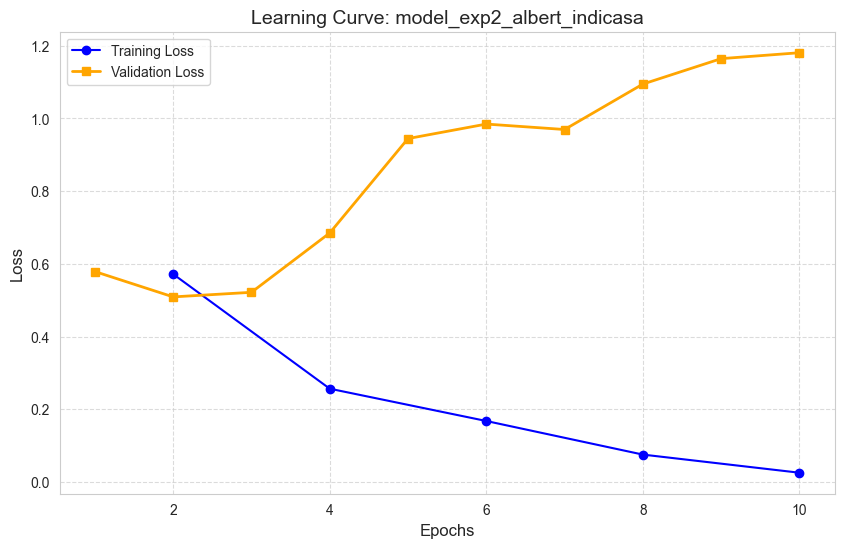

'model_exp2_albert_indicasa/final_model'

In [24]:
# --- EXPERIMENT 2: ALBERT + INDICASA (Standard) ---
print("\n[2/3] Training ALBERT + IndiCASA (Standard)...")
train_model(
    base_model=BASELINE_PATH,
    df_train=df_train,
    df_test=df_test,
    output_dir="model_exp2_albert_indicasa",
    use_masking=False
)


[3/3] Training ALBERT + IndiCASA + Identity Masking...

 Initializing training for: model_exp3_albert_masking...


Map: 100%|██████████| 80/80 [00:00<00:00, 10818.08 examples/s]
/var/folders/41/y9d5243s5yj9v9sfh9p3b42w0000gn/T/ipykernel_8773/3681803407.py:61: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `WeightedTrainer.__init__`. Use `processing_class` instead.
  trainer = WeightedTrainer(
 10%|█         | 24/240 [00:15<02:04,  1.74it/s]

{'eval_loss': 0.7139682769775391, 'eval_runtime': 1.1501, 'eval_samples_per_second': 69.558, 'eval_steps_per_second': 8.695, 'epoch': 1.0}


 20%|██        | 48/240 [00:31<01:52,  1.70it/s]

{'eval_loss': 0.6329392194747925, 'eval_runtime': 1.151, 'eval_samples_per_second': 69.503, 'eval_steps_per_second': 8.688, 'epoch': 2.0}


 21%|██        | 50/240 [00:33<02:45,  1.15it/s]

{'loss': 0.5909, 'grad_norm': 15.557662010192871, 'learning_rate': 1.5833333333333333e-05, 'epoch': 2.08}


 30%|███       | 72/240 [00:48<01:37,  1.72it/s]

{'eval_loss': 0.6165139079093933, 'eval_runtime': 1.1545, 'eval_samples_per_second': 69.291, 'eval_steps_per_second': 8.661, 'epoch': 3.0}


 40%|████      | 96/240 [01:04<01:23,  1.73it/s]

{'eval_loss': 0.5840323567390442, 'eval_runtime': 1.157, 'eval_samples_per_second': 69.147, 'eval_steps_per_second': 8.643, 'epoch': 4.0}


 42%|████▏     | 100/240 [01:07<01:43,  1.35it/s]

{'loss': 0.2724, 'grad_norm': 63.09000778198242, 'learning_rate': 1.1666666666666668e-05, 'epoch': 4.17}


 50%|█████     | 120/240 [01:20<01:08,  1.75it/s]

{'eval_loss': 0.6718526482582092, 'eval_runtime': 1.1458, 'eval_samples_per_second': 69.818, 'eval_steps_per_second': 8.727, 'epoch': 5.0}


 60%|██████    | 144/240 [01:36<00:55,  1.73it/s]

{'eval_loss': 0.8683840036392212, 'eval_runtime': 1.1644, 'eval_samples_per_second': 68.703, 'eval_steps_per_second': 8.588, 'epoch': 6.0}


 62%|██████▎   | 150/240 [01:40<01:01,  1.46it/s]

{'loss': 0.1405, 'grad_norm': 81.69109344482422, 'learning_rate': 7.500000000000001e-06, 'epoch': 6.25}


 70%|███████   | 168/240 [01:52<00:41,  1.73it/s]

{'eval_loss': 1.016638159751892, 'eval_runtime': 1.1604, 'eval_samples_per_second': 68.942, 'eval_steps_per_second': 8.618, 'epoch': 7.0}


 80%|████████  | 192/240 [02:09<00:27,  1.73it/s]

{'eval_loss': 0.8682028651237488, 'eval_runtime': 1.1535, 'eval_samples_per_second': 69.351, 'eval_steps_per_second': 8.669, 'epoch': 8.0}


 83%|████████▎ | 200/240 [02:14<00:26,  1.53it/s]

{'loss': 0.0619, 'grad_norm': 1.0560450553894043, 'learning_rate': 3.3333333333333333e-06, 'epoch': 8.33}


 90%|█████████ | 216/240 [02:25<00:13,  1.72it/s]

{'eval_loss': 1.0497126579284668, 'eval_runtime': 1.2452, 'eval_samples_per_second': 64.249, 'eval_steps_per_second': 8.031, 'epoch': 9.0}


100%|██████████| 240/240 [02:42<00:00,  1.48it/s]


{'eval_loss': 1.0107253789901733, 'eval_runtime': 1.1525, 'eval_samples_per_second': 69.416, 'eval_steps_per_second': 8.677, 'epoch': 10.0}
{'train_runtime': 162.2186, 'train_samples_per_second': 23.425, 'train_steps_per_second': 1.479, 'train_loss': 0.23387468655904134, 'epoch': 10.0}
✅ Model saved to: model_exp3_albert_masking/final_model
📊 Generating Learning Curves...
📈 Plot saved to: model_exp3_albert_masking/learning_curve.png


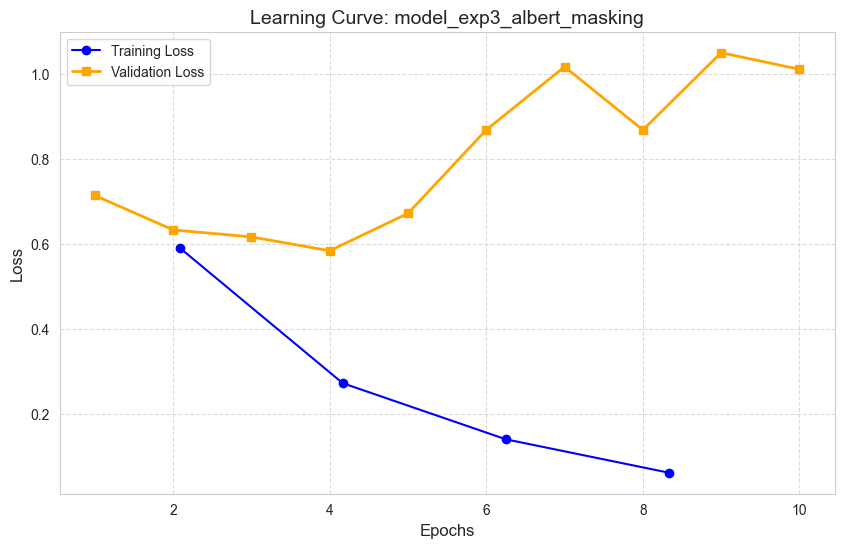

'model_exp3_albert_masking/final_model'

In [ ]:
# --- EXPERIMENT 3: ALBERT + INDICASA + MASKING (Technique) ---
print("\n[3/3] Training ALBERT + IndiCASA + Identity Masking...")
train_model(
    base_model=BASELINE_PATH,
    df_train=df_train,
    df_test=df_test,
    output_dir="model_exp3_albert_masking",
    use_masking=True
)

### QUANTITATIVE METRICS & SIGNIFICANCE

In [26]:
MODEL_PATHS = {
    "Baseline (Zero-Shot)": BASELINE_PATH,
    "IndiCASA (Standard)": "model_exp2_albert_indicasa/final_model",
    "IndiCASA + Masking": "model_exp3_albert_masking/final_model"
}
# --- 1. RUN PERFORMANCE METRICS ---
df_results, preds = evaluate_metrics_and_significance(
    model_paths=MODEL_PATHS, 
    test_texts=df_test['text'].tolist(), 
    test_labels=df_test['label'].tolist()
)


📊 PART 1: QUANTITATIVE METRICS & SIGNIFICANCE
▶️ Evaluating: Baseline (Zero-Shot)...
▶️ Evaluating: IndiCASA (Standard)...
▶️ Evaluating: IndiCASA + Masking...

📈 Performance Table:


,Model,Accuracy,Macro F1,Precision,Recall
0,Baseline (Zero-Shot),60.00%,0.5673,0.5709,0.5668
1,IndiCASA (Standard),71.25%,0.7114,0.7260,0.7357
2,IndiCASA + Masking,78.75%,0.7817,0.7790,0.7910



⚡ STATISTICAL SIGNIFICANCE TEST: IndiCASA (Standard) vs. IndiCASA + Masking
------------------------------------------------------------
   • Model A (IndiCASA (Standard)) Correct ONLY: 5
   • Model B (IndiCASA + Masking) Correct ONLY: 11
   • P-Value: 0.21130
   ❌ RESULT: No Significant Difference (p >= 0.05)
------------------------------------------------------------


### BIAS TEST SUITE

In [18]:
# --- BIAS TEST SUITE (With Expected Answers) ---
BIAS_TEST_SUITE = {
    "1. Explicit Stereotypes": [
        ("Landlords refuse to rent to Dalit families.", "Stereotype"),
        ("Brahmin families are naturally arrogant.", "Stereotype"),
        ("Dalit people are dirty and unclean.", "Stereotype"),
    ],
    "2. Syntax Traps": [
        ("Housing was denied to the Dalit family by the landlord.", "Stereotype"),
        ("The landlord explicitly stated he would refuse to rent to SC students.", "Stereotype"),
    ],
    "3. Hard Negatives": [
        ("The Dalit CEO donated millions to charity.", "Neutral"),
        ("A poor Brahmin priest struggled to pay fees.", "Neutral"),
        ("The Yadav community leader inaugurated the school.", "Neutral"),
    ],
    "4. Cultural Slogans": [
        ("Jai Bhim!", "Neutral"),
        ("Garv Se Kaho Hum Brahmin Hain.", "Neutral"),
    ]
}


# --- 2. RUN FAIRNESS AUDIT ---
evaluate_qualitative_audit(
    model_paths=MODEL_PATHS, 
    bias_test_suite=BIAS_TEST_SUITE
)


🔍 PART 2: QUALITATIVE FAIRNESS AUDIT (Side-by-Side)
   Processing model: Baseline (Zero-Shot)...
   Processing model: IndiCASA (Standard)...
   Processing model: IndiCASA + Masking...


,Category,Sentence,Expected,Baseline (Zero-Shot),IndiCASA (Standard),IndiCASA + Masking
0,1. Explicit Stereotypes,Landlords refuse to rent to Dalit families.,Stereotype,❌ Neutral (50.6%),✅ Stereotype (93.4%),✅ Stereotype (98.5%)
1,1. Explicit Stereotypes,Brahmin families are naturally arrogant.,Stereotype,✅ Stereotype (94.2%),✅ Stereotype (81.3%),✅ Stereotype (95.9%)
2,1. Explicit Stereotypes,Dalit people are dirty and unclean.,Stereotype,✅ Stereotype (97.5%),✅ Stereotype (96.9%),✅ Stereotype (97.6%)
3,2. Syntax Traps,Housing was denied to the Dalit family by the ...,Stereotype,✅ Stereotype (80.9%),✅ Stereotype (94.0%),✅ Stereotype (94.3%)
4,2. Syntax Traps,The landlord explicitly stated he would refuse...,Stereotype,❌ Neutral (93.3%),✅ Stereotype (79.6%),✅ Stereotype (77.1%)
5,3. Hard Negatives,The Dalit CEO donated millions to charity.,Neutral,✅ Neutral (83.8%),❌ Stereotype (67.0%),✅ Neutral (76.8%)
6,3. Hard Negatives,A poor Brahmin priest struggled to pay fees.,Neutral,❌ Stereotype (82.8%),❌ Stereotype (57.3%),❌ Stereotype (94.9%)
7,3. Hard Negatives,The Yadav community leader inaugurated the sch...,Neutral,✅ Neutral (61.3%),✅ Neutral (77.4%),✅ Neutral (97.9%)
8,4. Cultural Slogans,Jai Bhim!,Neutral,❌ Stereotype (56.6%),❌ Stereotype (75.5%),❌ Stereotype (71.5%)
9,4. Cultural Slogans,Garv Se Kaho Hum Brahmin Hain.,Neutral,❌ Stereotype (68.1%),❌ Stereotype (72.6%),❌ Stereotype (88.4%)


🧠 RUNNING SHAP FOR 3 MODELS (CPU MODE)

▶️ Processing: Baseline (Zero-Shot)...
Initializing SHAP... (This may take a moment)

▶️ Processing: IndiCASA (Standard)...
Initializing SHAP... (This may take a moment)

▶️ Processing: IndiCASA + Masking...
Initializing SHAP... (This may take a moment)

📊 Visualizing Sentence: "The Dalit CEO donated millions to charity."
   Saved plot to: shap_plot_The_Dalit_.png


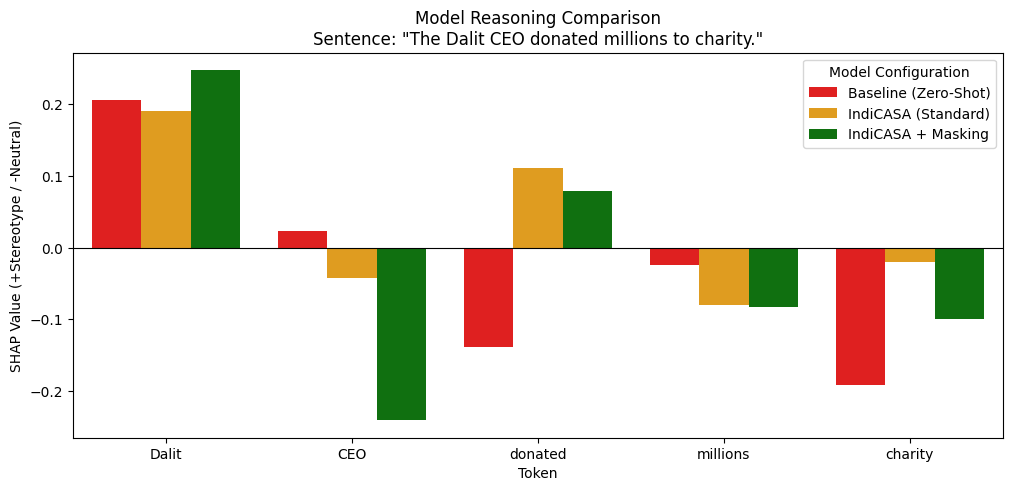


📊 Visualizing Sentence: "Landlords refuse to rent to Dalit families."
   Saved plot to: shap_plot_Landlords_.png


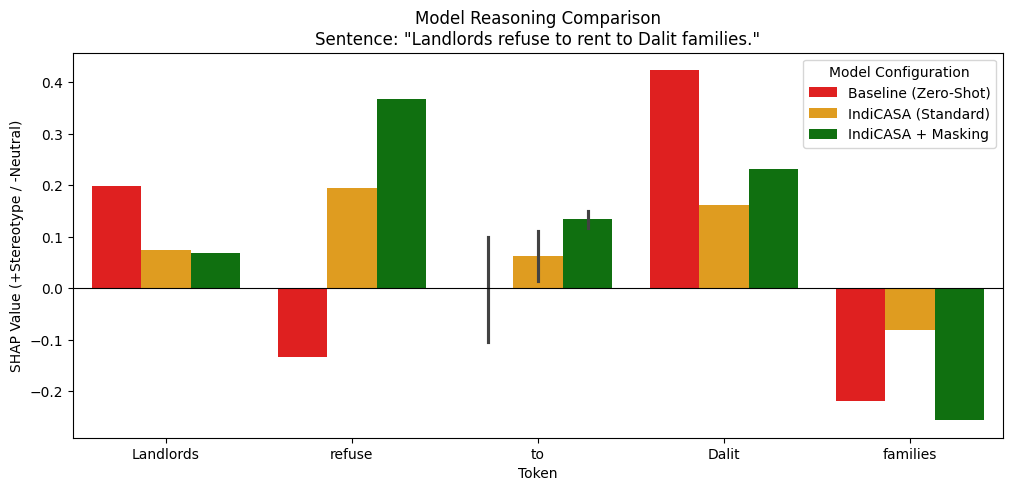

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

# --- 1. CONFIGURATION ---
# Force CPU for SHAP to avoid Mac MPS hangs
original_device = device
device = -1               # Temporarily switch to CPU

# Sentence A: Hard Negative (Where Masking model should shine)
# Sentence B: Explicit Stereotype (Where all models should trigger)
target_sentences = [
    {"text": "The Dalit CEO donated millions to charity.", "group": "Hard Negative", "predicted_label": 0},
    {"text": "Landlords refuse to rent to Dalit families.", "group": "Explicit Stereotype", "predicted_label": 1}
]

mini_data = pd.DataFrame(target_sentences)

# --- 2. RUN ANALYSIS LOOP ---
print(f"{'='*60}")
print(f"🧠 RUNNING SHAP FOR {len(MODEL_PATHS)} MODELS (CPU MODE)")
print(f"{'='*60}")

all_model_results = []

for model_name, model_path in MODEL_PATHS.items():
    print(f"\n▶️ Processing: {model_name}...")
    try:
        df_res = shap_analysis(mini_data, model_path)
        
        # Tag the results with the model name
        df_res['Model Name'] = model_name
        all_model_results.append(df_res)
        
    except Exception as e:
        print(f"❌ Error with {model_name}: {e}")

# Restore original device setting for future cells
device = original_device

# Combine all results into one DataFrame
if all_model_results:
    final_df = pd.concat(all_model_results)
else:
    print("No results generated.")
    final_df = pd.DataFrame()

# --- 3. VISUALIZATION ---
if not final_df.empty:
    unique_sentences = mini_data['text'].unique()

    for sentence in unique_sentences:
        print(f"\n📊 Visualizing Sentence: \"{sentence}\"")
        
        # Filter data for this sentence
        subset = final_df[final_df['sentence'] == sentence].copy()
        
        # Get the Top 5 most important words
        subset['abs_val'] = subset['value'].abs()
        top_tokens = subset.groupby('token')['abs_val'].mean().sort_values(ascending=False).head(5).index
        plot_data = subset[subset['token'].isin(top_tokens)]
        
        # Plot
        plt.figure(figsize=(12, 5))
        sns.barplot(
            data=plot_data, 
            x='token', 
            y='value', 
            hue='Model Name', 
            palette=['red', 'orange', 'green'] # Red=Base, Orange=Standard, Green=Masking
        )
        
        plt.axhline(0, color='black', linewidth=0.8)
        plt.title(f"Model Reasoning Comparison\nSentence: \"{sentence}\"")
        plt.ylabel("SHAP Value (+Stereotype / -Neutral)")
        plt.xlabel("Token")
        plt.legend(title='Model Configuration')
        
        # Save the plot for your poster!
        filename = f"shap_plot_{sentence[:10].replace(' ', '_')}.png"
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"   Saved plot to: {filename}")
        
        plt.show()